In [1]:
import sys
from os.path import exists
from timeit import default_timer as timer

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

from numba import njit, jit, vectorize, float64, prange
from scipy import stats

# global settings for matplotlib
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11
plt.rc("text", usetex=False)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [2]:
def confidence_intervals(sample_variances, p):
    """
    Returns the 100(1-p)% confidence intervals
    sample_variances    ----------
    sample_variances: array
        array of sample variances
    
    p: float between 0 and 1 exclusive
        p-value for confidence interval
        
    Returns
    -------
    intervals: array of floats
        |x - μ| < intervals, where X is the sample mean
        
    Notes
    -----
    Calculated as
        `stats.t.ppf(q = 1 - p/2, df=n-1) * np.sqrt(sample_variances)/np.sqrt(n)`
    where n = `len(sample_variances)`
    """
    n = len(sample_variances)
    intervals = stats.t.ppf(q = 1 - p/2, df=n-1) * np.sqrt(sample_variances)/np.sqrt(n)
    return intervals

@njit
def complex_to_real2(cmplx):
    """
    Returns the real an imaginary parts as a 2-tuple
    """
    re = np.real(cmplx)
    im = np.imag(cmplx)
    return re, im

def dashed_heading(text, length):
    """Pretty printing headings flanked by dashes."""
    dash_length = max(length - len(text), 0)
    ldash_length = dash_length // 2
    rdash_length = dash_length - ldash_length
    ldash = "-" * ldash_length
    rdash = "-" * rdash_length
    return ldash + text + rdash

In [3]:
@njit
def random_uniform(low = 0.0, high = 1.0, size = 1, seed = 0):
    """
    Returns 
    """
    if (seed):
        np.random.seed(seed)
        
    randos = np.random.random(size = size)
    scale = np.abs(high - low)
    randos *= scale
    randos += low
    return randos

@njit
def random_uniform_orthogonal(nax, l_bounds, u_bounds, seed = 0):
    """
    TODO: license
    TODO: docstring
    TODO: seeding?
    """
    if (seed):
        np.random.seed(seed)
        
    N = np.power(nax, 2)
    x_scale = (u_bounds[0] - l_bounds[0])/N
    y_scale = (u_bounds[1] - l_bounds[1])/N
    x0 = l_bounds[0]
    y0 = l_bounds[1]
    xlist = np.arange(N).reshape((nax,nax))
    ylist = np.arange(N).reshape((nax,nax))
    x_randos = np.empty(N, dtype = np.float64)
    y_randos = np.empty(N, dtype = np.float64)
    for i in range(nax):
        xlist[i] = np.random.permutation(xlist[i])
        ylist[i] = np.random.permutation(ylist[i])
    for i in range(nax):
        for j in range(nax):
            x_randos[i*nax + j] = x0 + x_scale * (xlist[i][j] + (np.random.random()))
            y_randos[i*nax + j] = y0 + y_scale * (ylist[j][i] + (np.random.random()))
    return x_randos, y_randos

In [4]:
@jit(nopython = True)
def default_escape_cond(z):
    return np.abs(z) >= 2

@jit(nopython = True)
def main_cardioid(arg):
    point = 0.5 * np.exp(1j*arg) - 0.25 * np.exp(2*1j*arg)
    return np.abs(point)

#@jit(nopython = True)
#def cardioid_escape_cond(z):
    #if np.abs(z) <= main_cardioid(z.)

def mandelbrot_batch_factory(escape_condition):
    @jit(nopython = True, parallel = True, nogil = True)
    def _mandelbrot_mc(max_iter, samples):
        iter_counts = np.empty(len(samples), dtype = np.int64)
        for i in prange(len(samples)):
            c = samples[i]
            zn = c
            for count in range(max_iter):
                zn = zn * zn + c
                if (escape_condition(zn)):
                    iter_counts[i] = count
                    break
                elif count == max_iter - 1:
                    iter_counts[i] = count
        return iter_counts
    return _mandelbrot_mc

mandelbrot_mc_default = mandelbrot_batch_factory(default_escape_cond)

@njit
def create_batch_uniform(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        np.random.seed(seed)
    samples_re = random_uniform(low = re_low, high = re_high, size = N)
    samples_im = random_uniform(low = im_low, high = im_high, size = N)
    samples = samples_re + 1j*samples_im
    return samples

@njit
def create_batch_orthogonal(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        np.random.seed(seed)
    nax = np.int64(np.ceil(np.sqrt(N)))
    l_bounds = (re_low, im_low)
    u_bounds = (re_high, im_high)
    samples_re, samples_im = random_uniform_orthogonal(nax, l_bounds, u_bounds)
    samples = samples_re + 1j*samples_im
    np.random.shuffle(samples)
    samples = samples[:N]
    return samples

def create_batch_sobol(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        sampler = stats.qmc.Sobol(d = 2, seed = seed)
    else:
        sampler = stats.qmc.Sobol(d = 2)
    l_bounds = [re_low, im_low]
    u_bounds = [re_high, im_high]
    
    samples_count = np.int64(np.ceil(np.log2(N)))
    
    samples = sampler.random_base2(samples_count)
    samples = stats.qmc.scale(samples, l_bounds, u_bounds)
    samples = samples[:,0] + 1j*samples[:,1]
    np.random.shuffle(samples)
    samples = samples[:N]
    return samples

def create_batch_lhc(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        sampler = stats.qmc.LatinHypercube(d = 2, seed = seed)
    else:
        sampler = stats.qmc.LatinHypercube(d = 2)
    re_scale = re_high - re_low
    im_scale = im_high - im_low
    samples = sampler.random(N)
    samples[:,0] *= re_scale
    samples[:,1] *= im_scale
    samples[:,0] += re_low
    samples[:,1] += im_low
    samples = samples[:,0] + 1j*samples[:,1]
    return samples

@njit
def genrand_uniform(low = 0.0, high = 1.0, size = 1, sampler = random_uniform):
    return sampler(low, high, size)

In [5]:
@jit(nopython = True)
def set_count_from_iter_counts(max_iter, iter_counts):
    set_count = 0
    for count in iter_counts:
        if count == max_iter - 1:
            set_count += 1
    return set_count

@jit(nopython = True)
def area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, max_iter):
    n = len(iter_counts)
    set_count = set_count_from_iter_counts(max_iter, iter_counts)
    domain_area = (re_high - re_low) * (im_high - im_low)
    return domain_area * set_count / n

In [6]:
N = 10**6
i = 1000
re_low, re_high = -2., 1.
im_low, im_high = 0, 1.5
area = (re_high - re_low) * (im_high - im_low)
samples = create_batch_uniform(N, re_low, re_high, im_low, im_high)

In [7]:
@jit(nopython = True, parallel = True, nogil = True)
def mandelbrot_mc(max_iter, samples):
    """
    Counts the number of complex numbers in `samples` that do
    not meet the escape condition in `max_iter` recursions of
    the Mandelbrot polynomial, z(n+1) = z(n)^2 + c
    
    The escape condition used is |z(n)| >= 2
    
    Parameters
    ----------
    max_iter: positive integer
        Value of n up to which z(n) is evaluated
    
    samples: array of complex numbers
        values of z(0)
        
    Returns
    -------
    set_count: positive integer
        Number of complex numbers in `samples` that remain
        that do not satisfy the escape condition
    """
    set_count = 0
    for i in prange(len(samples)):
        c = samples[i]
        zn = c
        for j in range(1, max_iter):
            zn = zn*zn + c
            if (np.abs(zn) > 2):
                # numba should recognize this as a critical section
                break
            elif j == max_iter - 1:
                set_count += 1
    return set_count

@jit(nopython = True, nogil = True, parallel = True)
def mandelbrot_mc_area(re_low, re_high, im_low, im_high, max_iter, samples):
    """
    Calculates estimator of the area of the Mandelbrot set
    
    Parameters
    ----------
    re_low, re_high, im_low, im_high: float or float-like
        corners of bounding rectangle in the complex plane
    
    max_iter: positive integer
        value of n up to which z(n) is evaluated
    
    samples: array of complex numbers
        list of c values, assumed to be drawn from a uniform distribution
        in the bounding region
        
    Returns
    -------
    area: default numpy float (float32 or float64)
        estimate of the area of the mandelbrot set
    """
    count = mandelbrot_mc(max_iter, samples)
    return mandelbrot_area(count, len(samples), re_low, re_high, im_low, im_high)

@jit(nopython = True)
def mandelbrot_area(count, N, re_low, re_high, im_low, im_high):
    """
    TODO: Add docstring
    """
    rect_area = (re_high - re_low) * (im_high - im_low)
    return rect_area * count / N

@jit(nopython = True)
def mandelbrot_mc_runs(max_iter, samples, runs_count):
    counts = np.zeros(runs_count)
    for _ in range(runs_count):
        counts[i] = mandelbrot_mc(max_iter, samples)
    return counts

@jit(nopython = True)
def sample_mean_variance(counts):
    """Returns sample mean and sample variance of input array
    Parameters
    ----------
    counts: array of numbers
    
    Returns: 2-tuple (sample mean, sample variance)
    """
    n = len(counts)
    assert n > 1
    sample_mean = np.mean(counts)
    sample_variance = np.sum(np.power(counts - sample_mean, 2))/(n - 1)
    return (sample_mean, sample_variance)

In [8]:
start_time = timer()
count = mandelbrot_mc_default(i, samples)
end_time = timer()
print(f"Execution time: {np.round(end_time - start_time, 2)} seconds")
print(area_from_iter_counts(re_low, re_high, im_low, im_high, count, i) * 2)

Execution time: 0.86 seconds
1.50903


In [9]:
# # [WARN]: On Linux Mint 20, 16GB RAM, 2GB swap space, the kernel crashes as it runs out of memory for N = 1.0e9
# N = 10**8
# # TODO: save large random arrays
# np.random.seed(10010)
# samples = create_batch_uniform(N, re_low, re_high, im_low, im_high)

In [10]:
# start_time = timer()
# count = mandelbrot_mc_default(i,samples)
# end_time = timer()
# print(end_time - start_time)

In [11]:
s = 10**5
i_values = np.array([10**i for i in range(1,8)], dtype = np.int64)

re_low, re_high = -2., 1.
im_low, im_high = 0, 1.5

npz_filename = "mc_fixed_s.npz"

mean_areas = np.empty(len(i_values))
sample_variances = np.empty(len(i_values))

if not exists(npz_filename):
    number_of_batches = 50
    for k,i in enumerate(i_values):
        areas_batch = np.empty(number_of_batches)
        for j in range(number_of_batches):
            samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas_batch[j] = est_area
        μ, svar = sample_mean_variance(areas_batch)
        mean_areas[k] = μ
        sample_variances[k] = svar
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']
    
confidence_95 = confidence_intervals(sample_variances, p = 0.05)

assert len(mean_areas) ==  len(sample_variances) == len(i_values)

In [12]:
print(mean_areas * 2)

[2.0245032 1.5460776 1.5106986 1.5087114 1.506816  1.5078708 1.5051294]


In [13]:
def compute_difference(values):
    i = [c for c in values]
    max_value = i[-1]

    return np.abs(i - max_value)

In [14]:

def iteration_variance_fixed_s(simulation_data, title):
    
    """
    Plots mean appromimated area with 95% CI
    or different i values and fixed s = 10^5, 
    together with the difference in means between 
    the maximum number of iterations and 
    other numbers of iterations
    
    """
    
    i_values = np.array([10**i for i in range(1,8)], dtype = np.int64)
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    confidence_95 = confidence_intervals(sample_variances, p = 0.05)

    difference = compute_difference(values = mean_areas)

    ax = plt.gca() 
    
    plt.plot(i_values, mean_areas, alpha = 0.5, marker = "h", color = "maroon")
    plt.fill_between(i_values, mean_areas - confidence_95, mean_areas + confidence_95, alpha = 0.2, color = 'brown')
    plt.xlabel("Number of iterations (i)")
    plt.ylim(0.8, 2.3)
    ax.set_ylabel("Mean approximated area A(i,s)", color = "maroon")
    ax.tick_params(axis='y', labelcolor= 'maroon')
    plt.grid(True)
    
    
    ax2 = ax.twinx()
    ax2.plot(i_values, difference, color = 'black', marker = "D", markersize = 4, linestyle = "-.", alpha = 0.6)
    for xitem, yitem in np.nditer([i_values, difference]):
        etiqueta = "{:.3f}".format(yitem)
        plt.annotate(etiqueta, (xitem, yitem), size = 11, color = "black", textcoords="offset points",xytext=(0,10),ha="center")
    ax2.tick_params(axis='y', labelcolor= 'black')
    ax2.set_ylabel("Difference |A(i,s) - A(j,s)|", color = 'black')
    
    ax.set_xscale('log')
    
    plt.savefig(title)
    plt.show() 

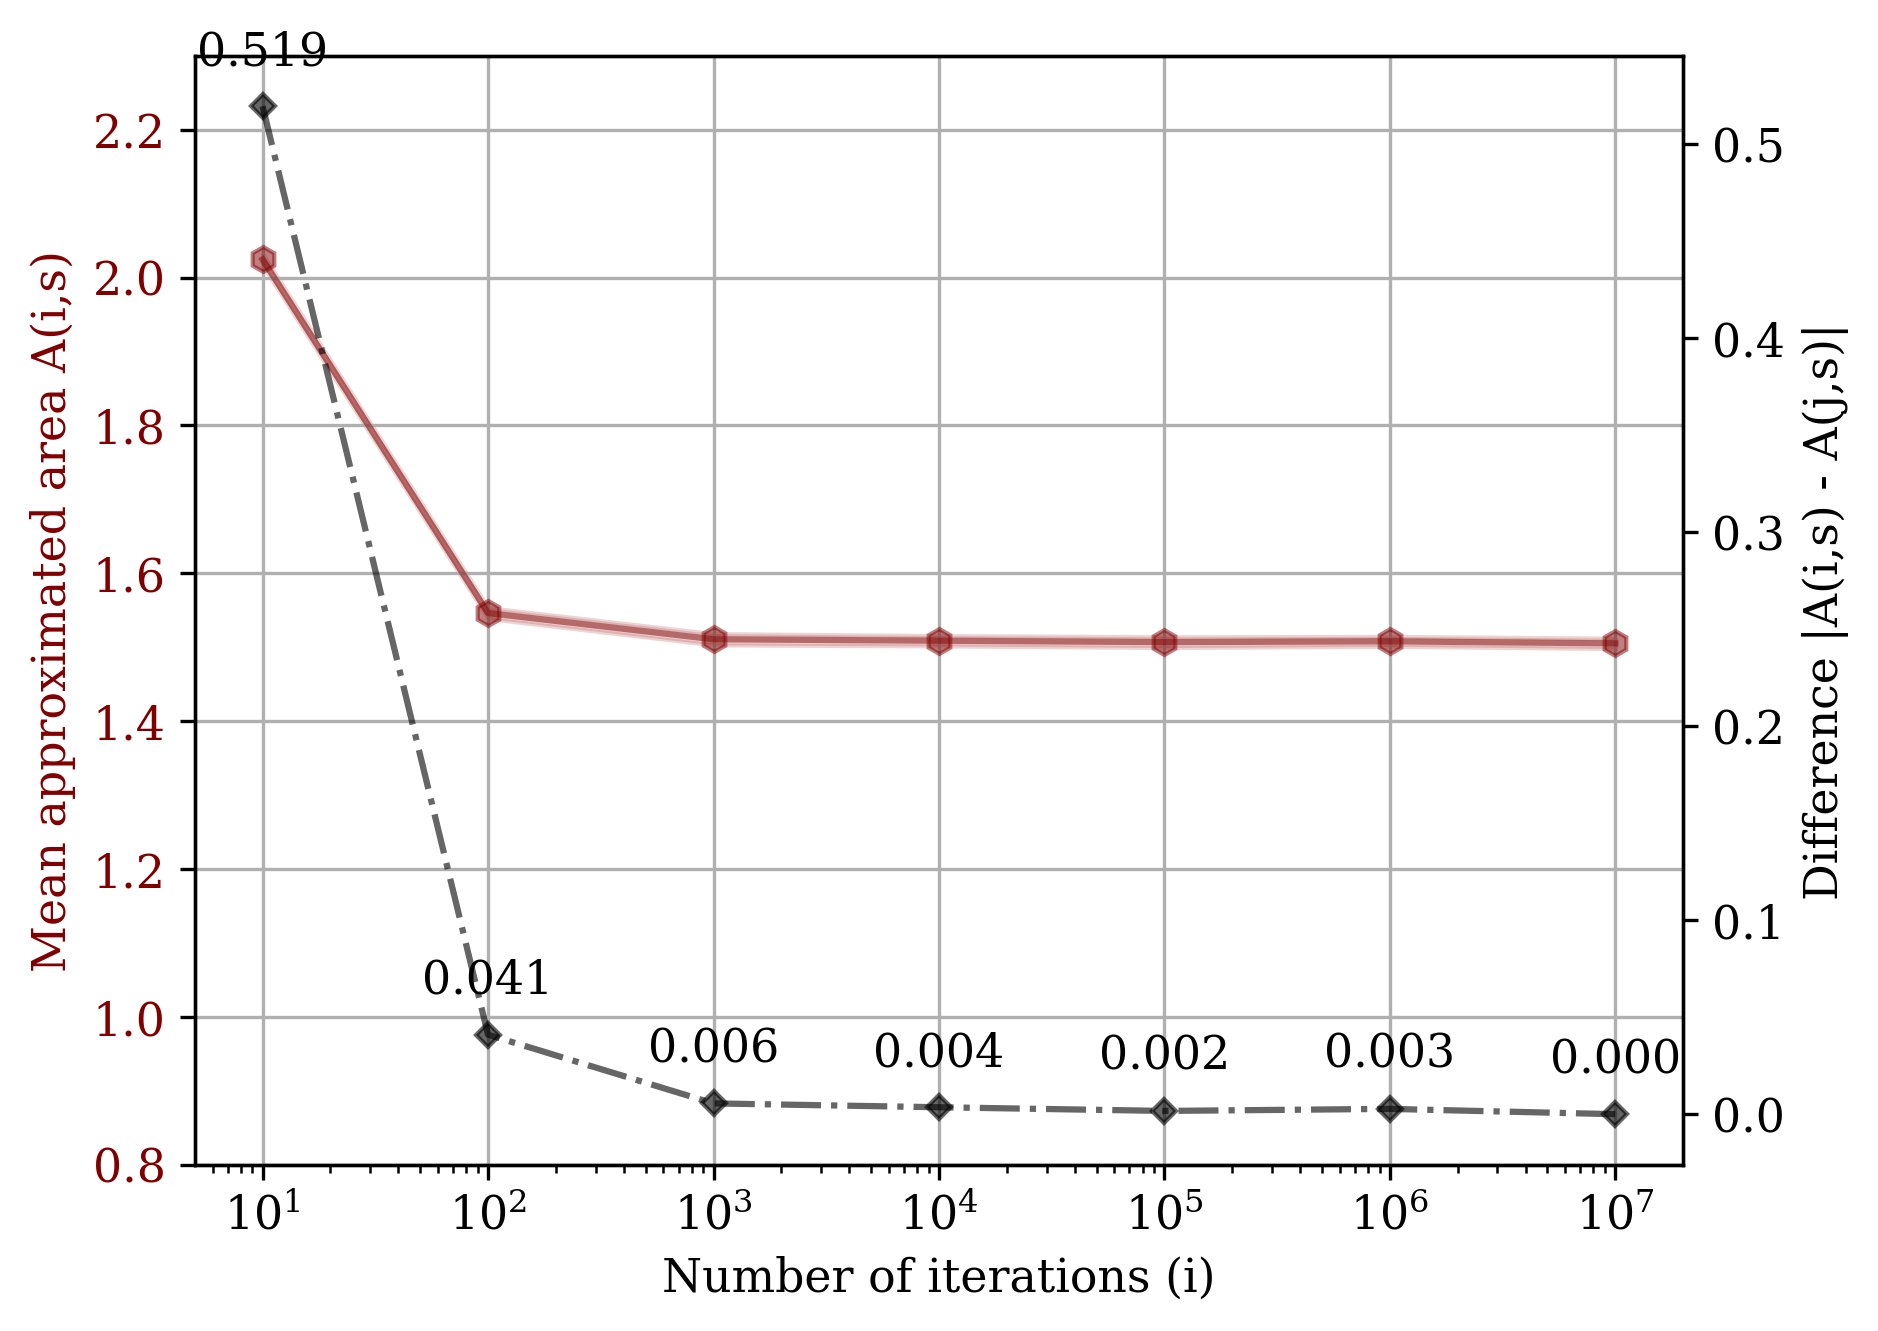

In [15]:
iteration_variance_fixed_s(simulation_data = "mc_fixed_s.npz" , title = "I_variance_s_fixed.png")

In [16]:
i = 2500
s_values = np.array([10**s for s in range(1,8)], dtype = np.int64)

re_low, re_high = -2., 1.
im_low, im_high = 0, 1.5

npz_filename = "mc_fixed_i.npz"

mean_areas = np.empty(len(s_values))
sample_variances = np.empty(len(s_values))

if not exists(npz_filename):
    number_of_batches = 50
    for k,s in enumerate(s_values):
        areas_batch = np.empty(number_of_batches)
        for j in range(number_of_batches):
            samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas_batch[j] = est_area
        μ, svar = sample_mean_variance(areas_batch)
        mean_areas[k] = μ
        sample_variances[k] = svar
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']
    
confidence_95 = confidence_intervals(sample_variances, p = 0.05)

assert len(mean_areas) ==  len(sample_variances) == len(s_values)

In [17]:
print(mean_areas * 2)

[1.602      1.5354     1.54296    1.51524    1.5111324  1.50780816
 1.50778742]


In [18]:
def sample_variance_fixed_i(simulation_data, title):

    """
    Plots mean appromimated area with 95% CI
    or different s values and fixed i = 2500, 
    together with the difference in 95% CI between 
    the maximum number of sample size and 
    other sample sizes

    """
    
    s_values = np.array([10**s for s in range(1,8)], dtype = np.int64)
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    confidence_95 = confidence_intervals(sample_variances, p = 0.05)
    
        
    print(confidence_95)
    
    
    difference = compute_difference(values = confidence_95)

    ax = plt.gca() 

    plt.plot(s_values, mean_areas, alpha = 0.5, color = "maroon", marker = "h")
    plt.fill_between(s_values, mean_areas - confidence_95, mean_areas + confidence_95, alpha = 0.2, color = "maroon")
    
    plt.xlabel("Sample size (s)")
    plt.ylim(0.8, 2.28)
    plt.xscale('log')
    ax.set_ylabel("Mean approximated area A(i,s)", color = "maroon")
    plt.grid(True)

    
    ax2 = ax.twinx()
    ax2.plot(s_values, difference, color = 'black', marker = "D", markersize = 4, linestyle = "-.", alpha = 0.6)
    for xitem, yitem in np.nditer([s_values, difference]):
        etiqueta = "{:.3f}".format(yitem)
        plt.annotate(etiqueta, (xitem, yitem), size = 11, color = "black", textcoords="offset points",xytext=(0,10),ha="center")
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylabel("Absolute difference in 95% CI", color = 'black')
    
    plt.savefig(title)
    plt.show() 

[0.64353691 0.20333394 0.06151341 0.02466575 0.00723486 0.00236985
 0.00068391]


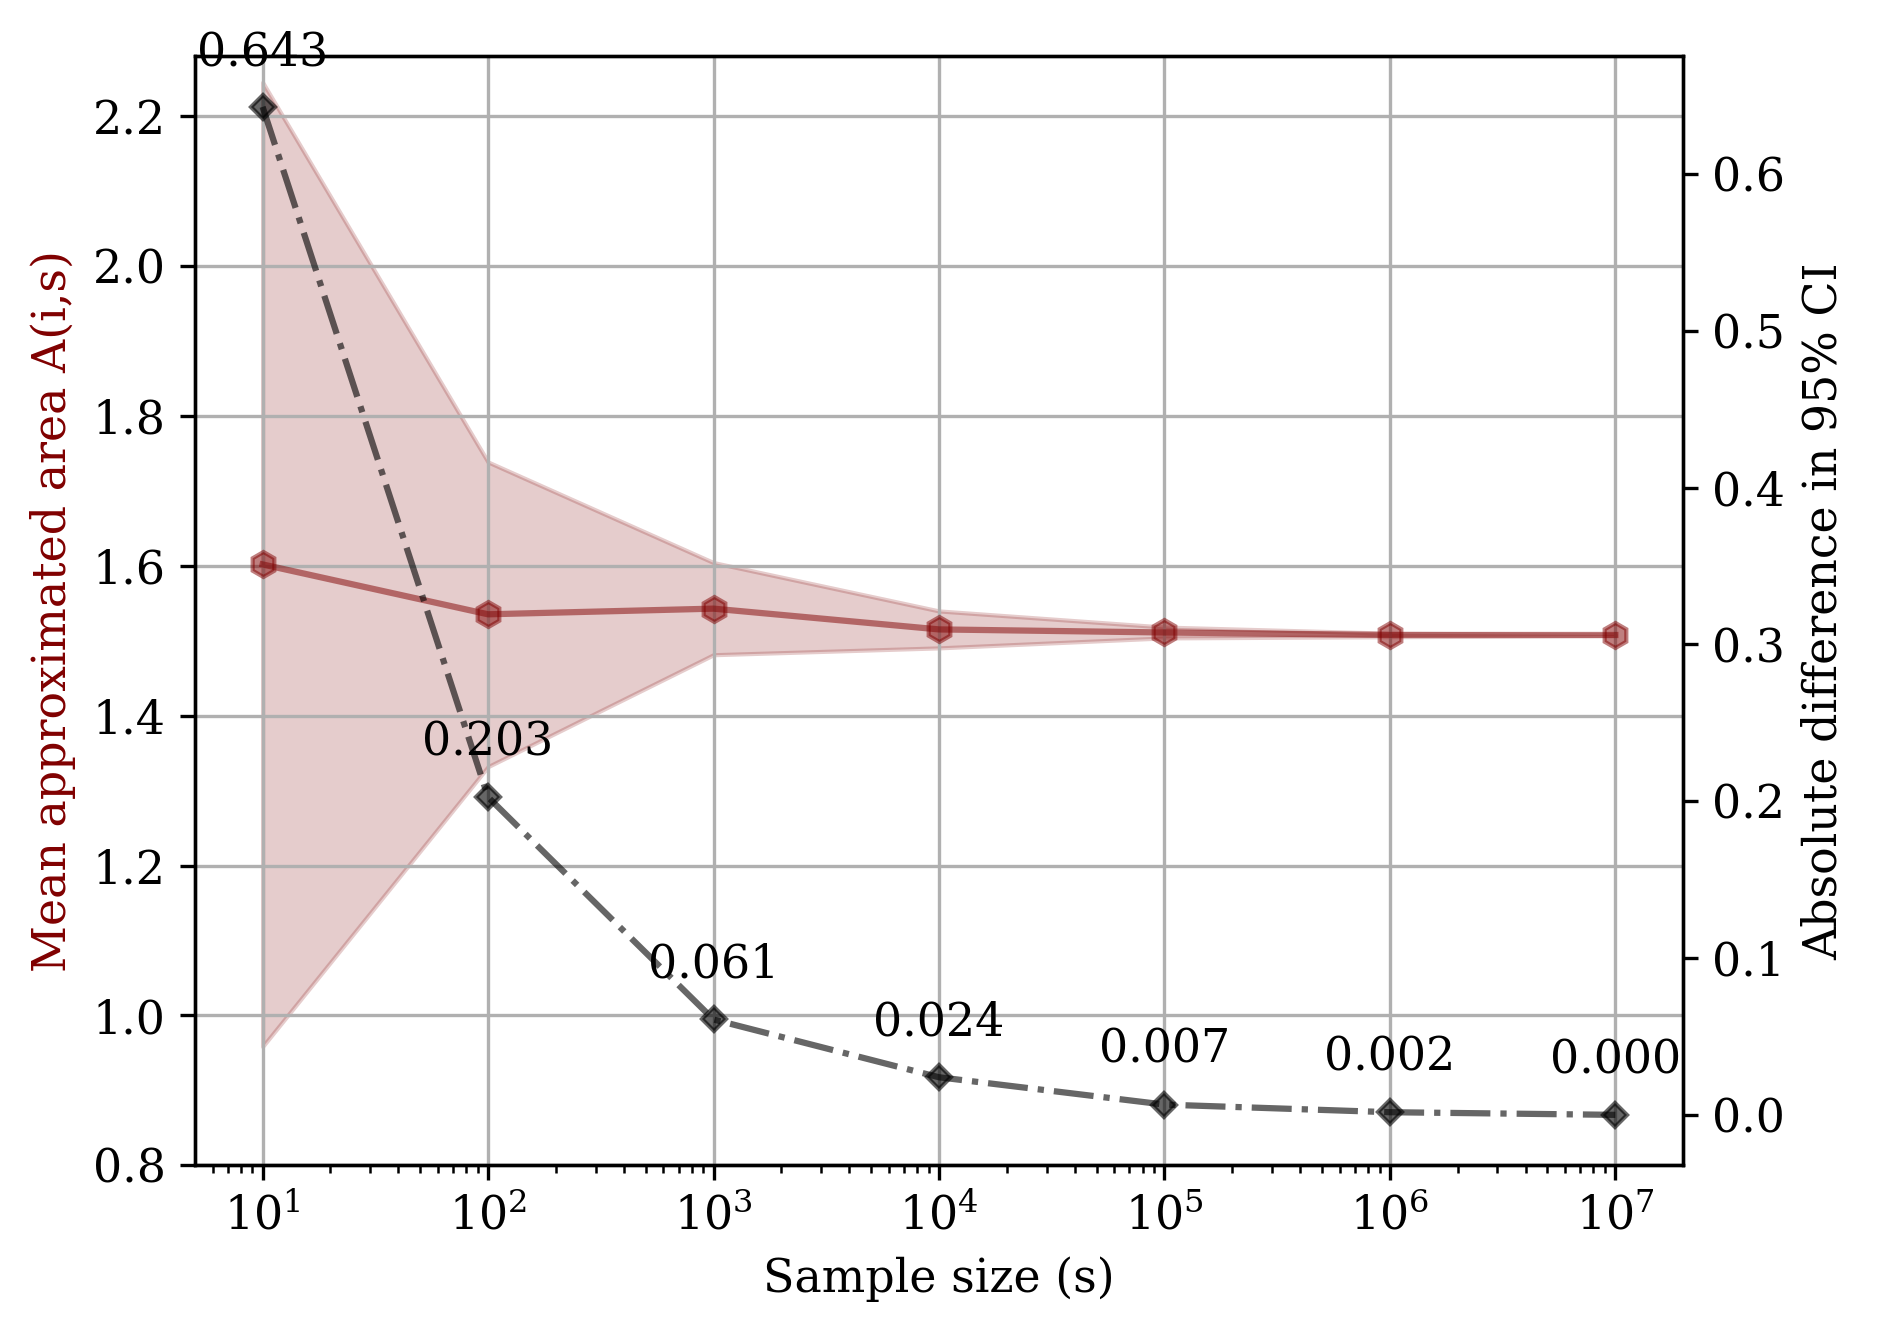

In [19]:
sample_variance_fixed_i(simulation_data = "mc_fixed_i.npz", title = "S_variance_i_fixed.png")

For a fixed $i$, $\lim_{s\to\infty}A_{i,s} = A_i > A_\text{M}$, i.e. we are essentially calculating the area of a superset of the Mandelbrot set, one that includes points that would have met the escape condition after $i$ iterations.

Given a strictly increasing sequence of $i$-values $\{i_1, i_2, \ldots i_n\}$, we would like to pick $i = i_k$ for the smallest $k$ such that $|A_{k+1} - A_{k}|$ is less than some threshold value.

Henceforth, we simulate only the top half of the mandelbrot set.

In [20]:
i_values = np.array([50, 100, 200, 500, 1000, 2000], dtype = np.int64) #TODO: tweak values
s_values = np.array([10**i for i in range(4,9)], dtype = np.int64)
if not exists("monte_carlo_random_sampling.npz"):
    re_low, re_high = -2., 1.
    im_low, im_high = 0, 1.5

    number_of_batches = 50
    mean_areas = np.zeros((len(i_values), len(s_values)))
    sample_variances = np.zeros((len(i_values), len(s_values)))

    start_time = timer()
    for k,i in enumerate(i_values):
        # repeat `number_of_batches` times for each s-value
        for l,s in enumerate(s_values):
            areas_batch = np.zeros(number_of_batches)
            for j in range(number_of_batches):
                samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
                iter_counts = mandelbrot_mc_default(i, samples)
                est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
                areas_batch[j] = est_area
            μ, svar = sample_mean_variance(areas_batch)
            mean_areas[k][l] = μ
            sample_variances[k][l] = svar
    end_time = timer()
    np.savez("monte_carlo_random_sampling.npz", mean_areas, sample_variances)
else:
    save_data = np.load("monte_carlo_random_sampling.npz")
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']

In [21]:
def sample_variance_smaller_i_plotter(simulation_data, title):
    
    """
    Plots mean appromimated area with 95% CI
    or different combinations of i and s values
    
    The range of i values considered are 50, 100, 200, 500, 1000, 200
    
    """
    
    s_values = np.array([10**i for i in range(4,9)], dtype = np.int64)
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    mean_i_50 = mean_areas[0]
    mean_i_100 = mean_areas[1]
    mean_i_200 = mean_areas[2]
    mean_i_500 = mean_areas[3]
    mean_i_1000 = mean_areas[4]
    mean_i_2000 = mean_areas[5]

    std_i_50 = np.sqrt(sample_variances[0])
    std_i_100 = np.sqrt(sample_variances[1])
    std_i_200 = np.sqrt(sample_variances[2])
    std_i_500 = np.sqrt(sample_variances[3])
    std_i_1000 = np.sqrt(sample_variances[4])
    std_i_2000 = np.sqrt(sample_variances[5])
    
    conf_95_50 = confidence_intervals(sample_variances[0], p = 0.05)
    conf_95_100 = confidence_intervals(sample_variances[1], p = 0.05)
    conf_95_200 = confidence_intervals(sample_variances[2], p = 0.05)
    conf_95_500 = confidence_intervals(sample_variances[3], p = 0.05)
    conf_95_1000 = confidence_intervals(sample_variances[4], p = 0.05)
    conf_95_2000 = confidence_intervals(sample_variances[5], p = 0.05)
    

    plt.plot(s_values, mean_i_50, color = "chocolate", alpha = 0.6, label = "i = 50", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_50 - conf_95_50, mean_i_50 + conf_95_50, alpha = 0.3, color = "chocolate")

    plt.plot(s_values, mean_i_100, color = "maroon", alpha = 0.6, label = "i = 100", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_100 - conf_95_100, mean_i_100 + conf_95_100, alpha = 0.3, color = "maroon")

    plt.plot(s_values, mean_i_200, color = "tomato", alpha = 0.6, label = "i = 200", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_200 - conf_95_200, mean_i_200 + conf_95_200, alpha = 0.3, color = "tomato")

    plt.plot(s_values, mean_i_500, color = "saddlebrown", alpha = 0.6, label = "i = 500", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_500 - conf_95_500, mean_i_500 + conf_95_500, alpha = 0.3, color = "saddlebrown")
    
    plt.plot(s_values, mean_i_1000, color = "purple", alpha = 0.6, label = "i = 1000", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_1000 - conf_95_1000, mean_i_1000 + conf_95_1000, alpha = 0.3, color = "purple")

    plt.plot(s_values, mean_i_2000, color = "darkorange", alpha = 0.6, label = "i = 2000", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_2000 - conf_95_2000, mean_i_2000 + conf_95_2000, alpha = 0.3, color = "darkorange")

    plt.hlines(1.50659, s_values[0], s_values[-1], label = "$A_M$", linestyles="dashed", linewidth = 1)

    plt.ylim(top=max(mean_i_50)+0.07) 
    plt.xscale('log')
    plt.xlabel("Sample sizes (s)")
    plt.ylabel("Mean approximated area A(i,s)")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="small", ncol=2)
    
    plt.savefig(title)
    plt.show() 
    
    
    

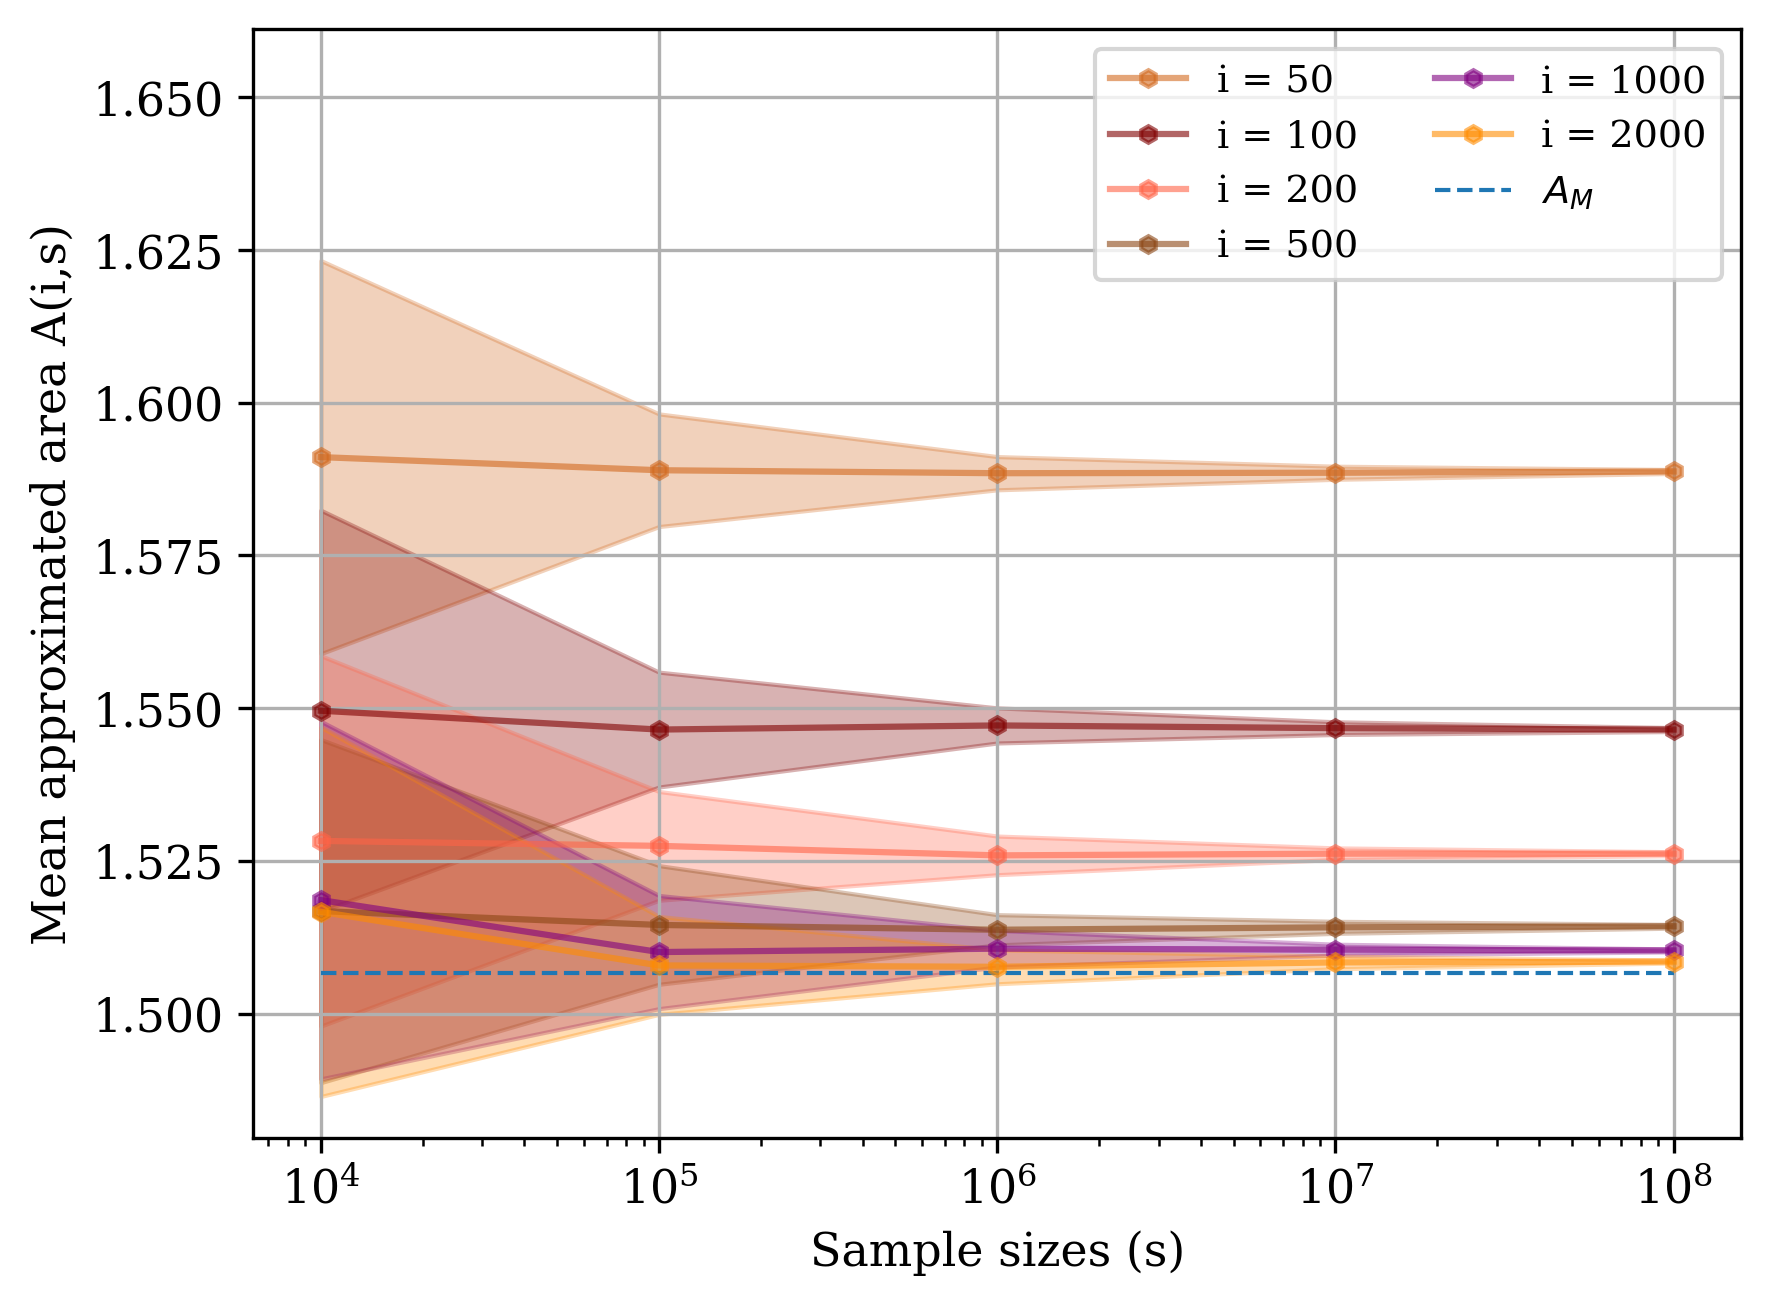

In [22]:
sample_variance_smaller_i_plotter(simulation_data = "monte_carlo_random_sampling.npz", title = "line_plot_samples_random_appendix.png")

In [23]:
i_values = np.array([1000, 2000, 3000, 4000, 5000], dtype = np.int64) #TODO: tweak values
s_values = np.array([10**i for i in range(4,8)], dtype = np.int64)
npz_filename = "mc_random_fullsave.npz"
if not exists(npz_filename):
    re_low, re_high = -2., 1.
    im_low, im_high = 0, 1.5

    number_of_batches = 50
    areas = np.empty((len(i_values),len(s_values), number_of_batches))
    mean_areas = np.zeros((len(i_values), len(s_values)))
    sample_variances = np.zeros((len(i_values), len(s_values)))

    start_time = timer()
    for k,i in enumerate(i_values):
        # repeat `number_of_batches` times for each s-value
        for l,s in enumerate(s_values):
            print(f"Working with i = {i}, s = {s}.")
#             areas_batch = np.zeros(number_of_batches)
            for j in range(number_of_batches):
                samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
                iter_counts = mandelbrot_mc_default(i, samples)
                est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
                areas[k][l][j] = est_area
            μ, svar = sample_mean_variance(areas[k][l])
            mean_areas[k][l] = μ
            sample_variances[k][l] = svar
    end_time = timer()
    np.savez(npz_filename, mean_areas, sample_variances, areas) 
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']
    areas = save_data['arr_2']


In [24]:
def sample_variance_larger_i_plotter(simulation_data, title):
    
    """
    Plots mean appromimated area with 95% CI
    or different combinations of i and s values
    
    The range of i values considered are 1000, 2000, 3000, 4000, 5000
    
    Plots for 1000 and 5000
    

    """
    
    s_values = np.array([10**i for i in range(4,8)], dtype = np.int64)
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    mean_i_1000 = mean_areas[0]
    mean_i_2000 = mean_areas[1]
    mean_i_3000 = mean_areas[2]
    mean_i_4000 = mean_areas[3]
    mean_i_5000 = mean_areas[4]

    std_i_1000 = np.sqrt(sample_variances[0])
    std_i_2000 = np.sqrt(sample_variances[1])
    std_i_3000 = np.sqrt(sample_variances[2])
    std_i_4000 = np.sqrt(sample_variances[3])
    std_i_5000 = np.sqrt(sample_variances[4])
    
    conf_95_1000 = confidence_intervals(sample_variances[0], p = 0.05)
    conf_95_2000 = confidence_intervals(sample_variances[1], p = 0.05)
    conf_95_3000 = confidence_intervals(sample_variances[2], p = 0.05)
    conf_95_4000 = confidence_intervals(sample_variances[3], p = 0.05)
    conf_95_5000 = confidence_intervals(sample_variances[4], p = 0.05)

    plt.plot(s_values, mean_i_1000, color = "purple", alpha = 0.6, label = "i = 1000", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_1000 - conf_95_1000, mean_i_1000 + conf_95_1000, alpha = 0.2, color = "purple")

    #plt.plot(s_values, mean_i_2000, color = "tomato", alpha = 0.6, label = "i = 2000")
    #plt.fill_between(s_values, mean_i_2000 - conf_95_2000, mean_i_2000 + conf_95_2000, alpha = 0.2, color = "tomato")

    #plt.plot(s_values, mean_i_3000, color = "darkgoldenrod", alpha = 0.6, label = "i = 3000", marker = "h", markersize = 4)
    #plt.fill_between(s_values, mean_i_3000 - conf_95_2000, mean_i_3000 + conf_95_2000, alpha = 0.2, color = "darkgoldenrod")

    #plt.plot(s_values, mean_i_4000, color = "orange", alpha = 0.6, label = "i = 4000")
    #plt.fill_between(s_values, mean_i_4000 - conf_95_4000, mean_i_4000 + conf_95_4000, alpha = 0.2, color = "orange")

    plt.plot(s_values, mean_i_5000, color = "darkgreen", alpha = 0.6, label = "i = 5000", marker = "h", markersize = 4)
    plt.fill_between(s_values, mean_i_5000 - conf_95_5000, mean_i_5000 + conf_95_5000, alpha = 0.2, color = "darkgreen")

    plt.hlines(1.50659, s_values[0], s_values[-1], label = "$A_M$", linestyles="dashed", linewidth = 1)

    #plt.xlim(10**5, 10**7) 
    plt.xscale('log')
    plt.xlabel("Sample sizes (s)")
    plt.ylabel("Mean approximated area A(i,s)")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="small")
    
    plt.savefig(title)
    plt.show() 

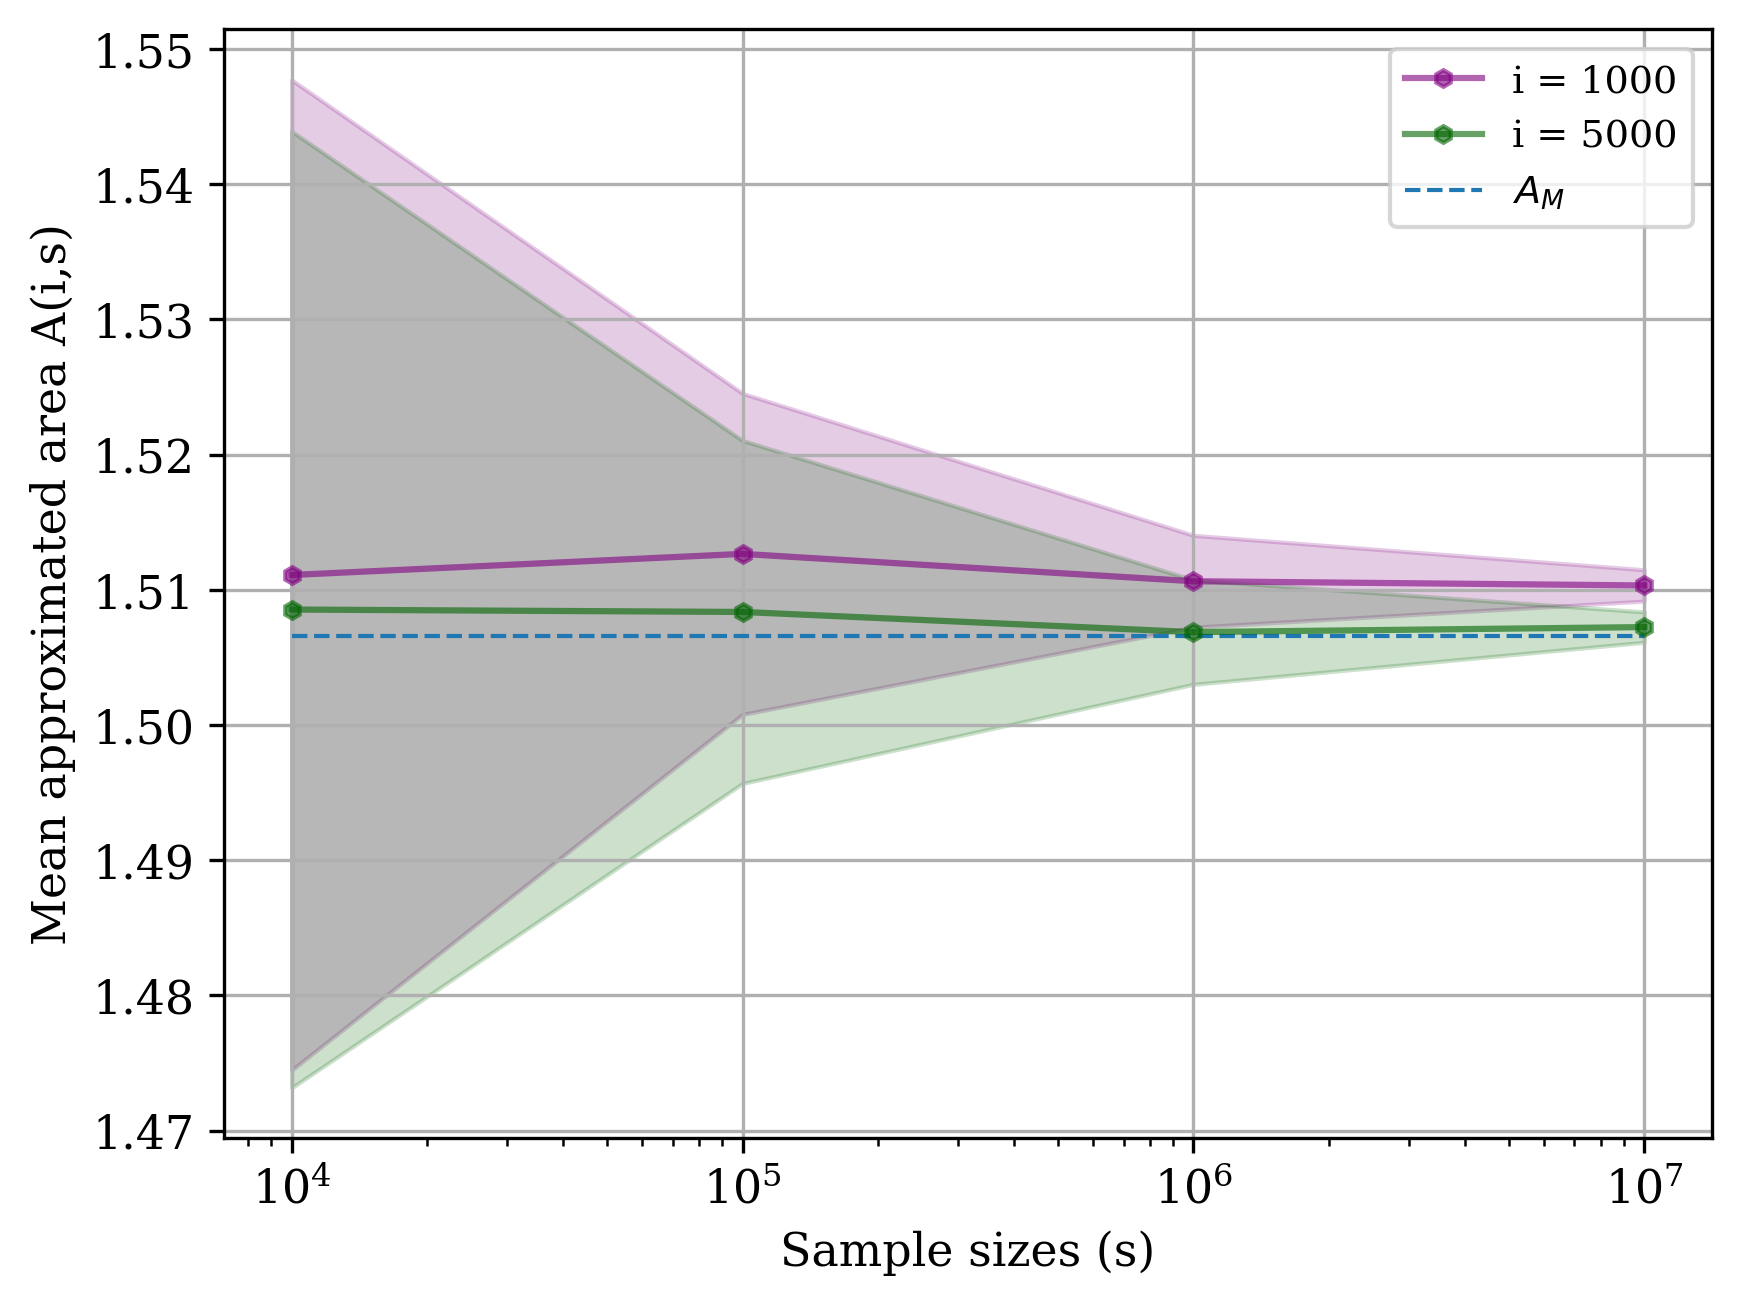

In [25]:
sample_variance_larger_i_plotter(simulation_data = "mc_random_fullsave.npz", title = "line_plot_samples_random.png")

In [26]:
# TODO - seed so that it does not change anymore

def sampling_methods_plotter(n, title, seed = 0):
    
    """
    Plots an example of sample size n for LHC and OS
    
    PRS is hashed out to make the plot more readable

    """
    if seed:
        np.random.seed(seed)
    
    nx = ny = n
    nsq = n**2
    
    #p_r = np.random.random((nsq, 2))
    
    sampler = stats.qmc.LatinHypercube(d=2, seed = np.random.randint(2**31))
    lhs = sampler.random(nsq)
    
    l_bounds, u_bounds = (0, 0), (1, 1)
    x_randos, y_randos = random_uniform_orthogonal(n, l_bounds, u_bounds, seed = np.random.randint(2**31))
    
    lhs_corr, _ = stats.pearsonr(lhs[:, 0], lhs[:, 1])
    os_corr, _ = stats.pearsonr(x_randos, y_randos)
    
    print('Pearsons correlation of LHS: %.3f' % lhs_corr)
    print('Pearsons correlation of OS: %.3f' % os_corr)
    
    fig = plt.figure(figsize=(5, 5))
    #plt.scatter(p_r[:, 0], p_r[:, 1], color="b", label="Pure random")
    plt.scatter(lhs[:, 0], lhs[:, 1], s=20, label="LHC", color='darkgreen')
    plt.scatter(x_randos, y_randos, s=20, color="chocolate", label="Orthogonal")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.hlines(np.arange(nsq)/nsq, 0, 1, alpha = 0.7, color="darkgreen")
    plt.vlines(np.arange(nsq)/nsq, 0, 1, alpha = 0.7, color="darkgreen")
    plt.hlines(np.arange(n)/n, 0, 1, color="chocolate", linewidth = 3)
    plt.vlines(np.arange(n)/n, 0, 1, color="chocolate", linewidth = 3)
    plt.grid(False)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend(loc = "best")
    plt.savefig(title)
    plt.show()

Pearsons correlation of LHS: 0.179
Pearsons correlation of OS: 0.136


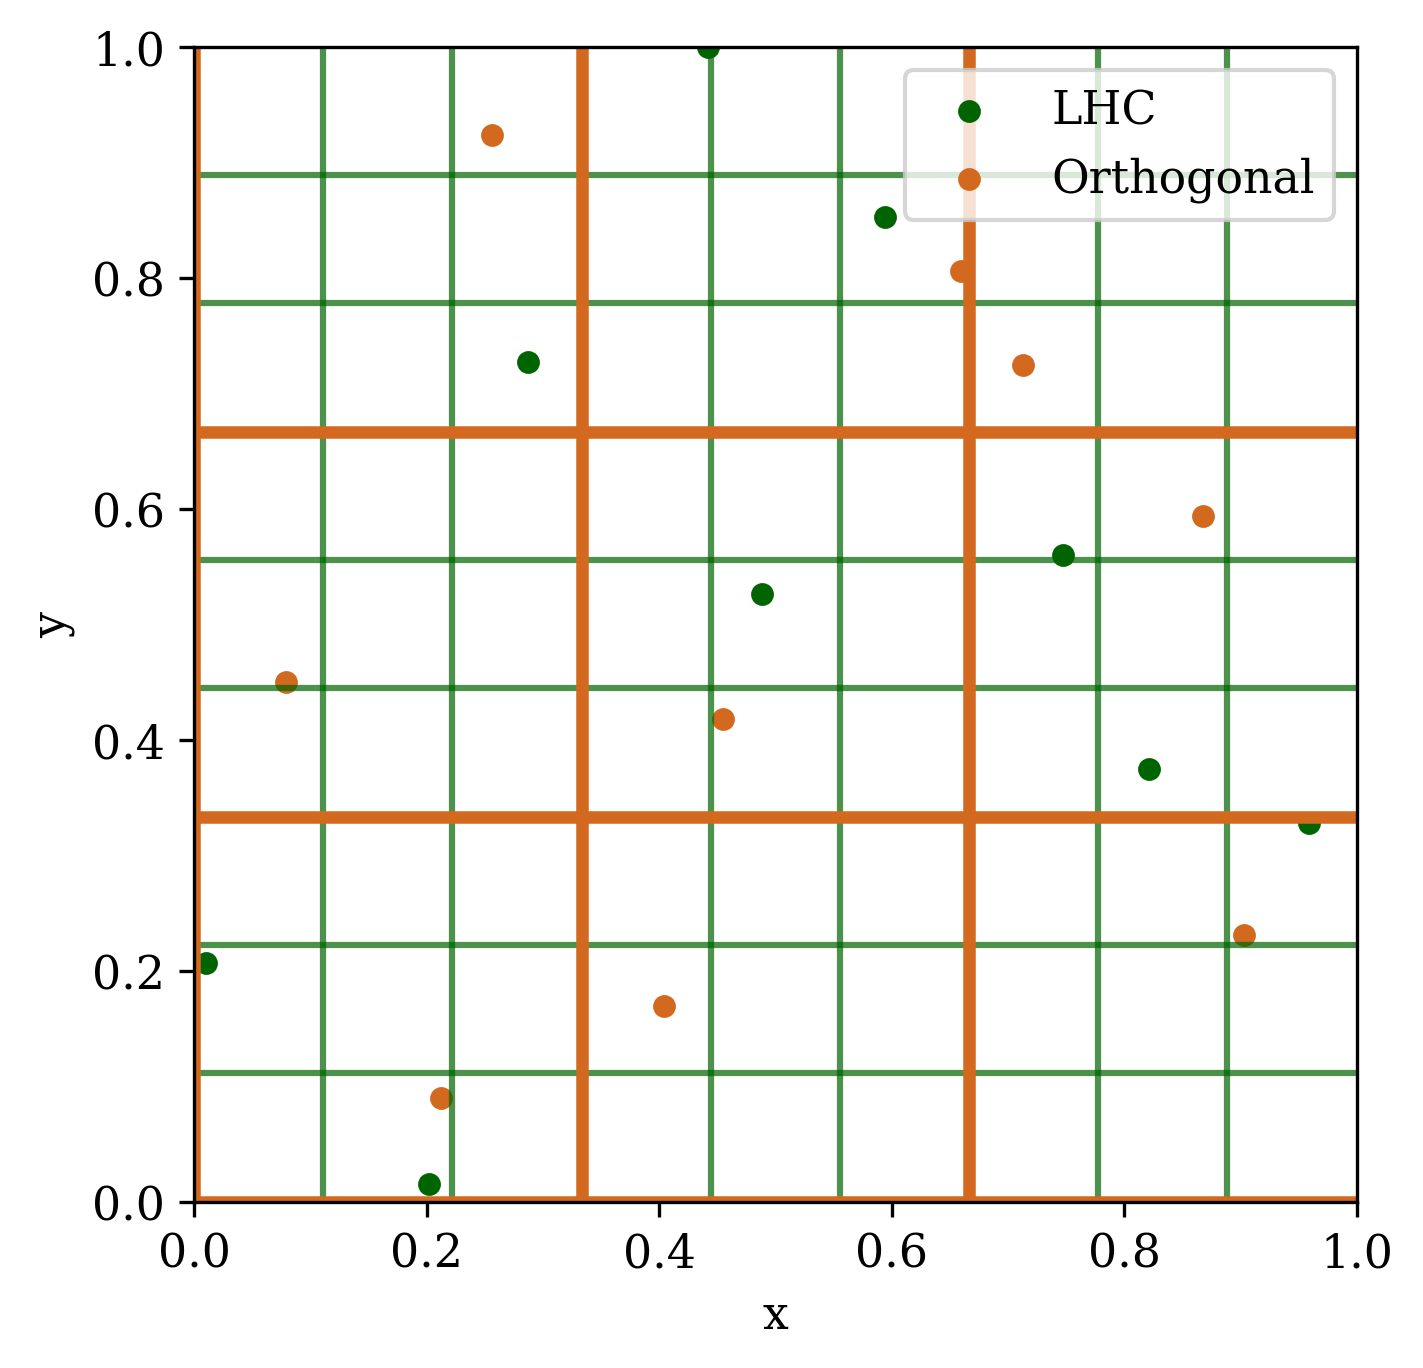

In [27]:
sampling_methods_plotter(n=3, title = "LHS_OS.png", seed = 2346)

## Comparison between PRS, LHC, and OS
Fix $i, s$ and compare for different sampling methods

In [28]:
i = 1000
s = 10**4 # 
number_of_batches = 300 # TODO: decide value from previous cell's results
# TODO: change name of data 400 good

npz_filename = "3_sampling_methods_one_run_10_4_300.npz"

re_low, re_high = -2., 1.
im_low, im_high = 0., 1.5

generators = [create_batch_uniform, create_batch_orthogonal, create_batch_lhc]

if not exists(npz_filename):
    areas = np.empty((3,number_of_batches))
    mean_areas = mean_areas = np.empty(3)
    sample_variances = np.empty(3)

    
    for k, method in enumerate(generators):
        for b in range(number_of_batches):
            samples = method(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas[k][b] = area
        μ, σsq = sample_mean_variance(areas[k])
        mean_areas[k] = μ
        sample_variances[k] = σsq
       
    print(mean_areas * 2)
    np.savez(npz_filename, mean_areas, sample_variances, areas)
else:
    save_data = np.load(npz_filename)
    indices = (f"arr_{i}" for i in range(3))
    mean_areas, sample_variances, areas = (save_data[i] for i in indices)

In [29]:

def sampling_methods_histogram(simulation_data, title):
    
    """
    Plots histogram and distribution from the simulation data
    using seaborn `displot`
    
    """
    
    data = np.load(simulation_data)
    
    areas = data['arr_2']*2
    
    df = pd.DataFrame((areas), index=["PS", "OS", "LHS"])
    
    df_t = df.T
    
    palette = sns.xkcd_palette(['maroon', 'pumpkin', 'olive green'])

    sns.set_style("ticks", 
                  {"xtick.major.size":8, "ytick.major.size":8, 'axes.grid': True})
    
    sns.axes_style("whitegrid")
    fig = sns.displot(df_t, bins = 50, kde = True, legend = False, palette=palette) #husl"CMRmap_r"
    
    plt.xlabel("Approximated area $A_{i,s}$")
    
    plt.legend(loc = 1, title = "Sampling methods", labels= ["LHS", "OS", "RS"])
    
    
    plt.savefig(title)

In [30]:
sampling_methods_histogram(simulation_data = "3_sampling_methods_one_run_10_4_300.npz", title = "Three_sampling_methods_histogram.png")

In [31]:
def f_test(x, y):
    
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    
    return f, p
    

In [32]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print( 
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}", 
          dashed_heading("", 80))

In [33]:
def sampling_methods_boxplot(simulation_data, title):
    
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot
    
    """
    
    data = np.load(simulation_data)
    
    areas = data['arr_2']*2

    ps_mean, ps_var = sample_mean_variance(areas[0])
    os_mean, os_var = sample_mean_variance(areas[1])
    lhs_mean, lhs_var = sample_mean_variance(areas[2])
    
    p = 0.05
    n = 300 # number of simulations 
    ps_ci = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(ps_var)/np.sqrt(n)
    os_ci = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(os_var)/np.sqrt(n)
    lhs_ci = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(lhs_var)/np.sqrt(n)

    print('Approximation with PS averaged', ps_mean, "±", ps_ci, "95% CI")
    print('Approximation with OS averaged', os_mean, "±", os_ci, "95% CI")
    print("Approximation with LHS averaged", lhs_mean, "±", lhs_ci, "95% CI")
    
    
    
    
    print("Pair-wise Welch-test:")
    print("PS and OS:")
    welch_ttest(areas[0], areas[1])
    
    print("PS and LHS:")
    welch_ttest(areas[0], areas[2])
    
    print("OS and LHS:")
    welch_ttest(areas[1], areas[2])
    
    
    
    # pair-wise T-test: 
    heading_length = 80
    
    def _heading(text):
        return dashed_heading(text, heading_length)
    
    print(_heading("Pair-wise T-tests"))
    
    corrected_p = 0.05 / 3 # bonferroni correction
    
    print("Corrected critical value (Bonferroni correction) is:", corrected_p)
    
    # 1. pr vs os:
    f1, p1 = f_test(areas[0], areas[1])
    
    if p1 < corrected_p:
        print(_heading("PR vs OS"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of PS equals to variance of OS")
        print("F-test statistic is:", f1, " and  p-value is:", p1)
        conclusion1 = "Null Hypothesis is rejected."
        
    else:
        print(_heading("PR vs OS"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of OS equals to variance of OS")
        print("F-test statistic is:", f1, " and  p-value is:", p1)
        conclusion1 = "Failed to reject the null hypothesis."
        
    print(conclusion1)

    
    # 2. pr vs lhs:
    f2, p2 = f_test(areas[0], areas[2])
    
    if p2 < corrected_p:
        print(_heading("PR vs LHS"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of PS equals to variance of LHS")
        print("F-test statistic is:", f2, " and  p-value is:", p2)
        conclusion2 = "Null Hypothesis is rejected."
        
    else:
        print(_heading("PR vs LHS"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of PS equals to variance of LHS")
        print("F-test statistic is:", f2, " and  p-value is:", p2)
        conclusion2 = "Failed to reject the null hypothesis."
        
    print(conclusion2)
    
    # 3. os vs lhs:
    f3, p3 = f_test(areas[1], areas[2])
    
    if p3 < corrected_p:
        print(_heading("OS vs LHS"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of OS equals to variance of LHS")
        print("F-test statistic is:", f3, " and  p-value is:", p3)
        conclusion3 = "Null Hypothesis is rejected."
        
    else:
        print(_heading("OS vs LHS"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of OS equals to variance of LHS")
        print("F-test statistic is:", f3, " and  p-value is:", p3)
        conclusion3 = "Failed to reject the null hypothesis."
        
    print(conclusion3)

    palette = sns.xkcd_palette(['maroon', 'pumpkin', 'olive green'])
    
    df = pd.DataFrame(np.transpose(areas), columns = ["PS", "OS", "LHS"])
    
    fig = sns.boxplot(data=df, palette=palette)
    
    plt.xlabel("Sampling Methods")
    plt.ylabel("Approximated area $A_{i,s}$")
    plt.savefig(title)

In [34]:
sampling_methods_boxplot(simulation_data = "3_sampling_methods_one_run_10_4_300.npz", title = "Boxplots.png")

Approximation with PS averaged 1.5085890000000013 ± 0.0036666356462334384 95% CI
Approximation with OS averaged 1.5099719999999985 ± 0.0006682361966140054 95% CI
Approximation with LHS averaged 1.5110369999999995 ± 0.0025430052203681557 95% CI
Pair-wise Welch-test:
PS and OS:
Welch's t-test= -0.7302 
 p-value = 0.4658 
 Welch-Satterthwaite Degrees of Freedom= 318.8402 --------------------------------------------------------------------------------
PS and LHS:
Welch's t-test= -1.0796 
 p-value = 0.2808 
 Welch-Satterthwaite Degrees of Freedom= 532.5982 --------------------------------------------------------------------------------
OS and LHS:
Welch's t-test= -0.7971 
 p-value = 0.4259 
 Welch-Satterthwaite Degrees of Freedom= 340.0961 --------------------------------------------------------------------------------
-------------------------------Pair-wise T-tests--------------------------------
Corrected critical value (Bonferroni correction) is: 0.016666666666666666
-------------------

## Sobol Sequences

In [35]:
def complex_to_real2(cmplx):
    re = np.real(cmplx)
    im = np.imag(cmplx)
    return re, im

In [36]:
def uniform_sobol_plotter(s, title): 
    
    re_low, re_high, im_low, im_high = 0, 1, 0, 1

    ortho_samples = create_batch_orthogonal(s, re_low, re_high, im_low, im_high, seed = np.random.randint(2**31))
    sobol_samples = create_batch_sobol(s, re_low, re_high, im_low, im_high, seed = np.random.randint(2**31))
    unifo_samples = create_batch_uniform(s, re_low, re_high, im_low, im_high, seed = np.random.randint(2**31))

    unifo_re, unifo_im = complex_to_real2(unifo_samples)

    sobol_re, sobol_im = complex_to_real2(sobol_samples)
    samples_unifo_256 = create_batch_uniform(256, 0, 1, 0, 1, seed = np.random.randint(2**31))
    samples_sobol_256 = create_batch_sobol(256, 0, 1, 0, 1, seed = np.random.randint(2**31))

    unifo_re_256, unifo_im_256 = complex_to_real2(samples_unifo_256)
    sobol_re_256, sobol_im_256 = complex_to_real2(samples_sobol_256)
    
    fig, axes = plt.subplots(2,2)
    axes[0][0].scatter(unifo_re_256, unifo_im_256, s = 2, c = 'maroon')
    axes[0][0].set_title('Uniform ($s =256$)', size = 10)
    axes[0][1].scatter(sobol_re_256, sobol_im_256, s = 2, c = "slategray")
    axes[0][1].set_title('Sobol ($s =256$)', size = 10)
    axes[1][0].scatter(unifo_re, unifo_im, s = 2, c = 'maroon')
    axes[1][0].set_title('Uniform ($s =2^{10}$)', size = 10)
    axes[1][1].scatter(sobol_re, sobol_im, s = 2, c = "slategray")
    axes[1][1].set_title('Sobol ($s =2^{10}$)', size = 10)

    for ax in axes.flat:
        ax.label_outer()
    
    
    plt.savefig(title)
    plt.show()

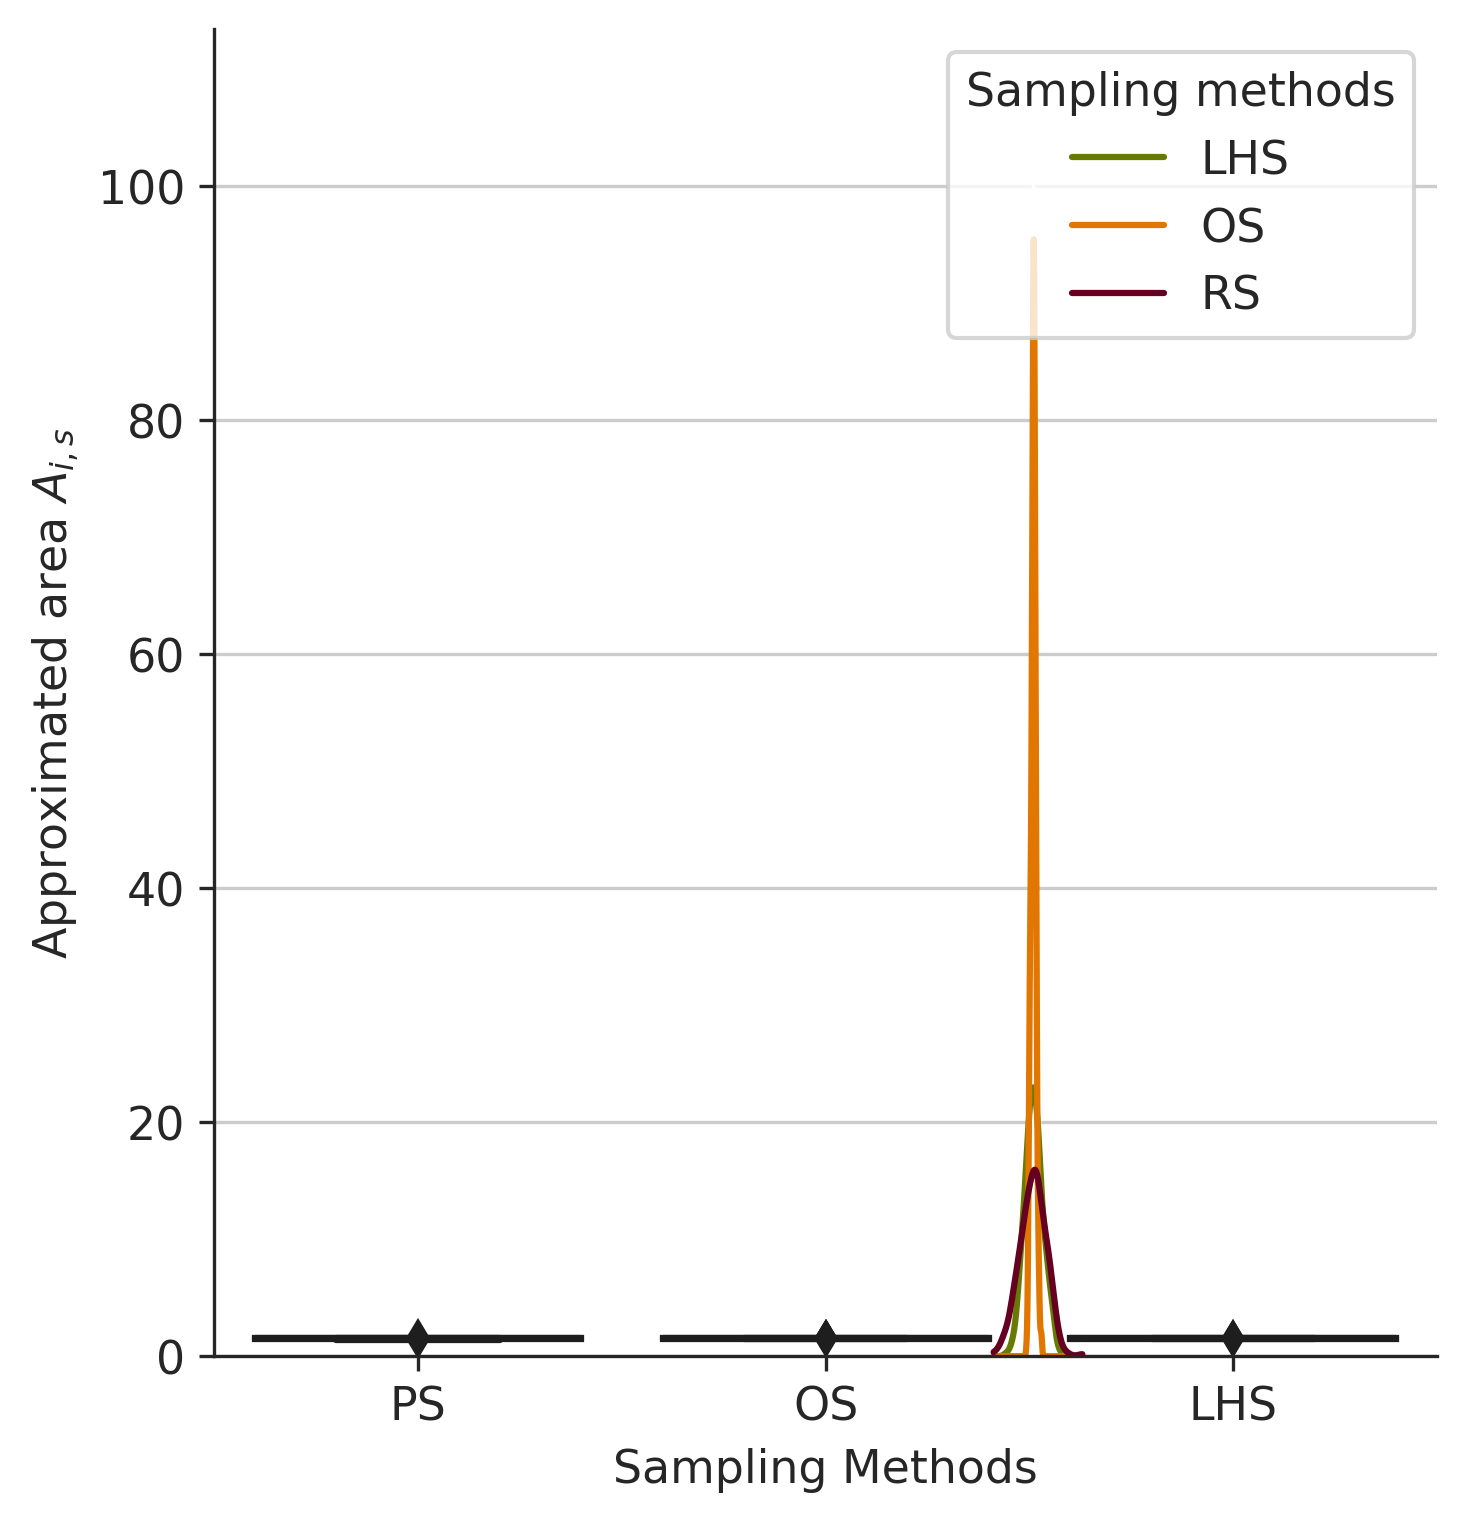

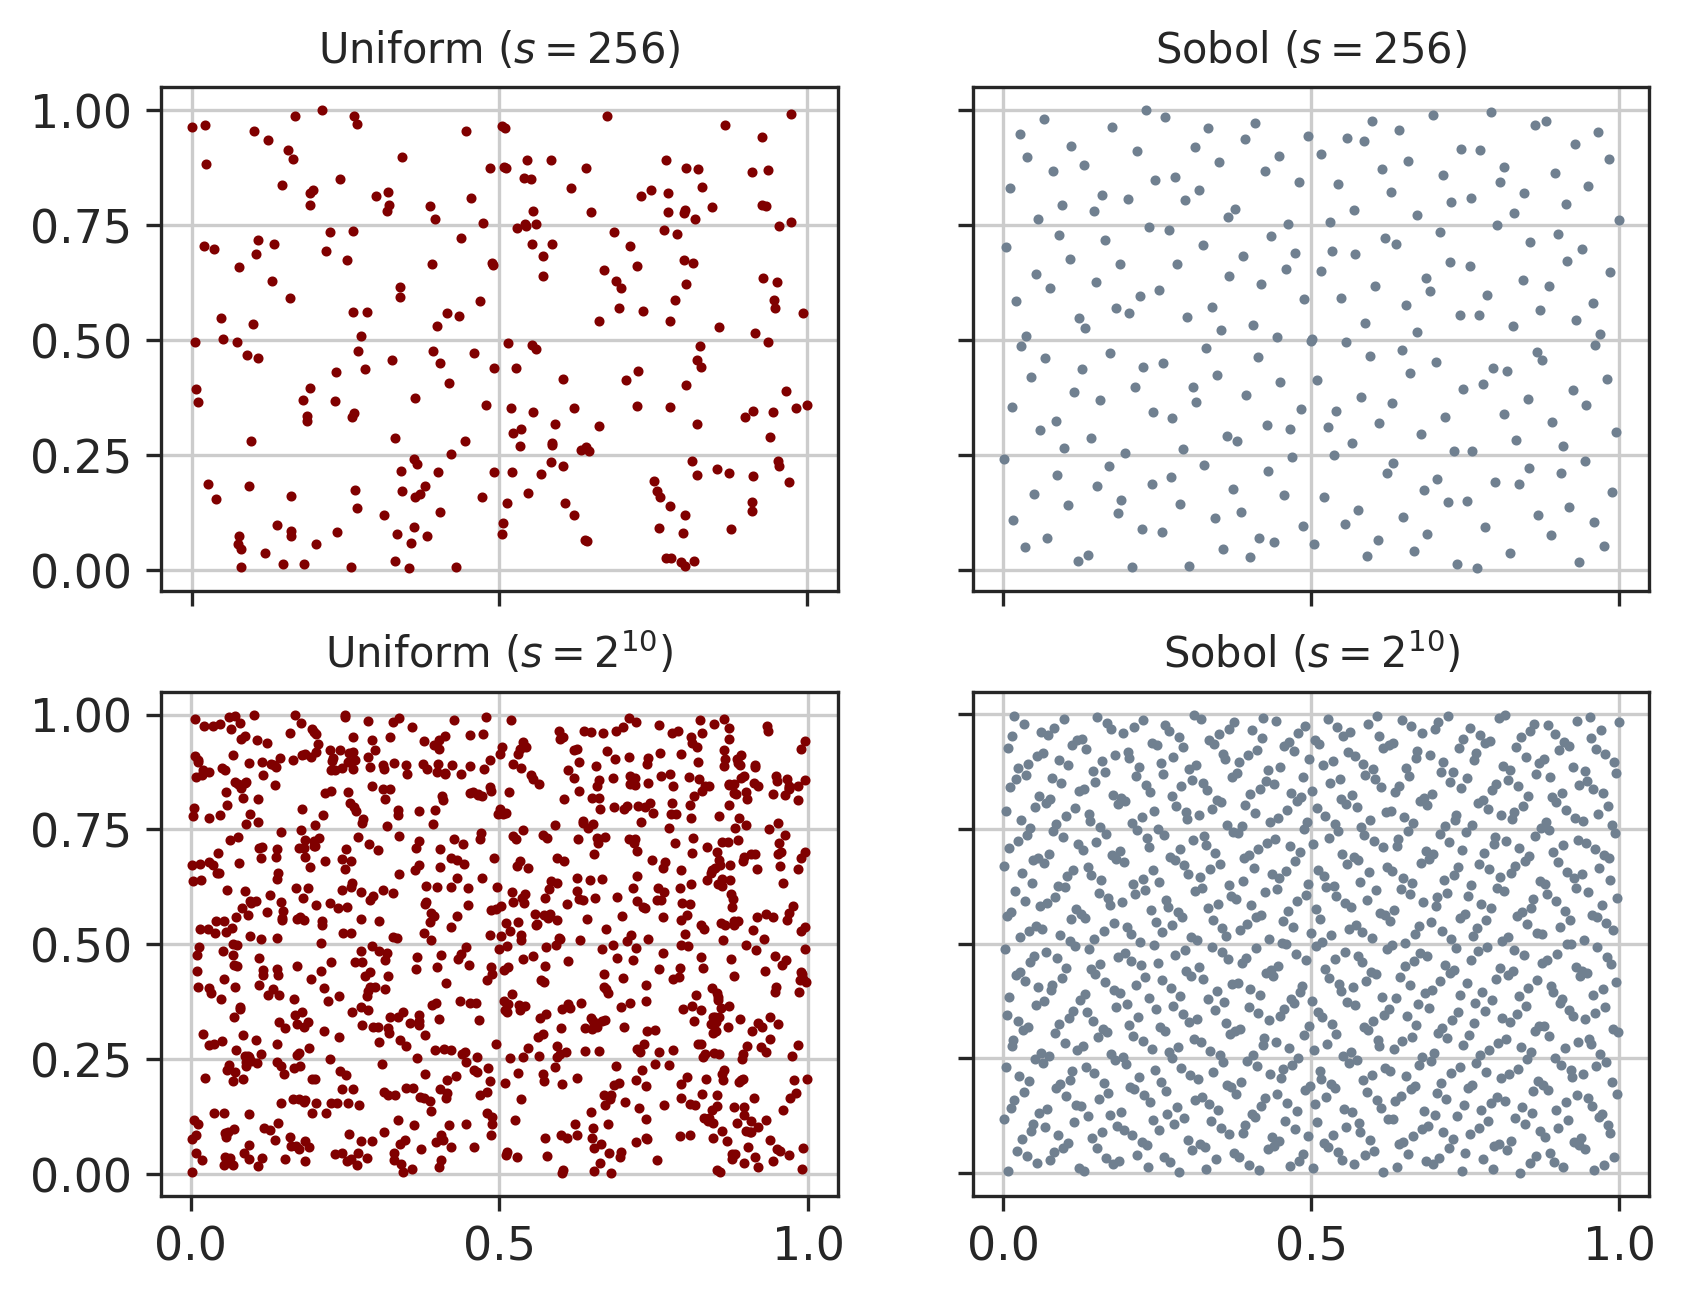

In [37]:
np.random.seed(13151)

uniform_sobol_plotter(s = 2**10, title = "Uniform_Sobol_scatter.png") 

In [38]:
# short-enough runtime
# TODO - write if not exist

number_of_batches = 50
sample_sizes = np.array([np.power(2,i) for i in range(6,15,2)])
batch_generators = [create_batch_uniform, create_batch_orthogonal, create_batch_sobol]
mean_discrepancies = np.empty((len(batch_generators), len(sample_sizes)))
sample_variances = np.empty((len(batch_generators), len(sample_sizes)))
npz_filename = "discrepancies_unifo_ortho_sobol.npz"
if not exists(npz_filename):
    for i, bgen in enumerate(batch_generators):
        for j, s in enumerate(sample_sizes):
            discrepancies_batch = np.empty(number_of_batches)
            for l in range(number_of_batches):
                samples = bgen(s, 0, 1, 0, 1, seed = np.random.randint(2**31))
                samples_R2 = np.stack([np.real(samples), np.imag(samples)], axis = 1)
                dscr = stats.qmc.discrepancy(samples_R2, workers = -1)
                discrepancies_batch[l] = dscr
            μ, svar = sample_mean_variance(discrepancies_batch)
            print(μ)
            mean_discrepancies[i][j] = μ
            sample_variances[i][j] = svar
    np.savez(npz_filename, mean_discrepancies, sample_variances)
else:
    save_data = np.load(npz_filename)
    mean_discrepancies = save_data['arr_0']
    sample_variances = save_data['arr_1'] 

In [39]:
def mean_discrepancies_OS_sobol_plotter(simulation_data, title):
    
    sample_sizes = np.array([np.power(2,i) for i in range(6,15,2)])
    
    data = np.load(simulation_data)
    
    mean_discrepancies = data['arr_0']
    sample_variances = data['arr_1'] 
    
    discr_OS = mean_discrepancies[1]
    discr_Sobol = mean_discrepancies[2]
    
    plt.plot(sample_sizes, discr_OS, label = "OS", color = "chocolate", marker = "h", markersize = 4)
    plt.plot(sample_sizes, discr_Sobol, label = "Sobol", color = "slategray", marker = "h", markersize = 4)
    
    plt.legend()
    plt.ylabel("Centered Discrepancy")
    plt.xscale('log', basex=2)
    plt.grid(alpha = 0.6)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()


<ipython-input-39-7140f37c0a6e>:18: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=2)


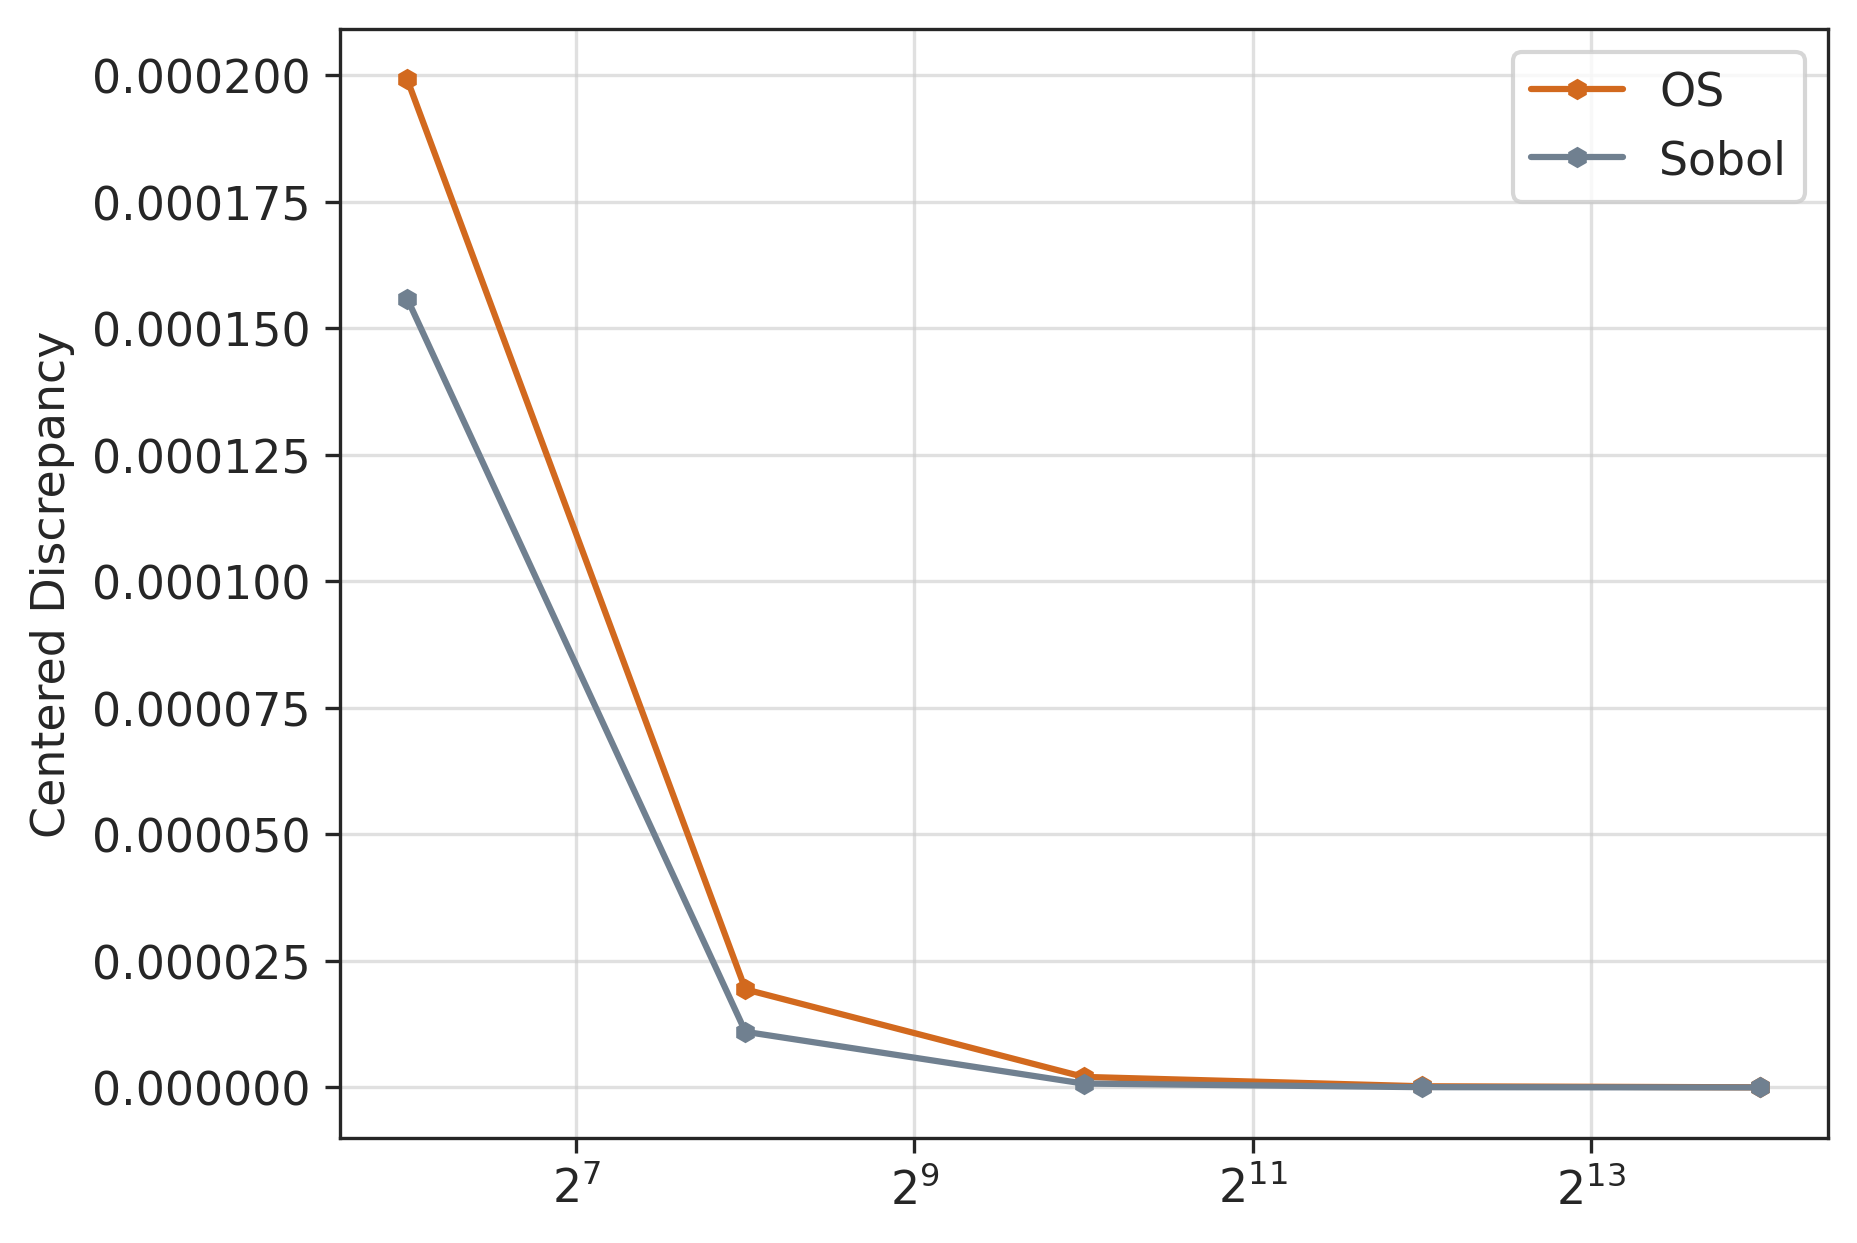

In [40]:
mean_discrepancies_OS_sobol_plotter(simulation_data = "discrepancies_unifo_ortho_sobol.npz", title = "Mean_discrepancies_Sobol_OS.png")

In [41]:
def mean_discrepancies_IID_sobol_plotter(simulation_data, title):
    sample_sizes = np.array([np.power(2,i) for i in range(6,15,2)])
    
    data = np.load(simulation_data)
    
    mean_discrepancies = data['arr_0']
    sample_variances = data['arr_1'] 
    
    discr_IID = mean_discrepancies[0]    
    discr_Sobol = mean_discrepancies[2]
    
    plt.plot(sample_sizes, discr_IID, label = "IID", color = "maroon", marker = "h", markersize = 4)
    plt.plot(sample_sizes, discr_Sobol, label = "Sobol", color = "slategray", marker = "h", markersize = 4)
    
    plt.ylabel("Centered Discrepancy")
    plt.xscale("log", basex = 2)
    plt.legend()
    plt.grid(alpha = 0.6)
    
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()


<ipython-input-41-f77d82777b83>:16: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale("log", basex = 2)


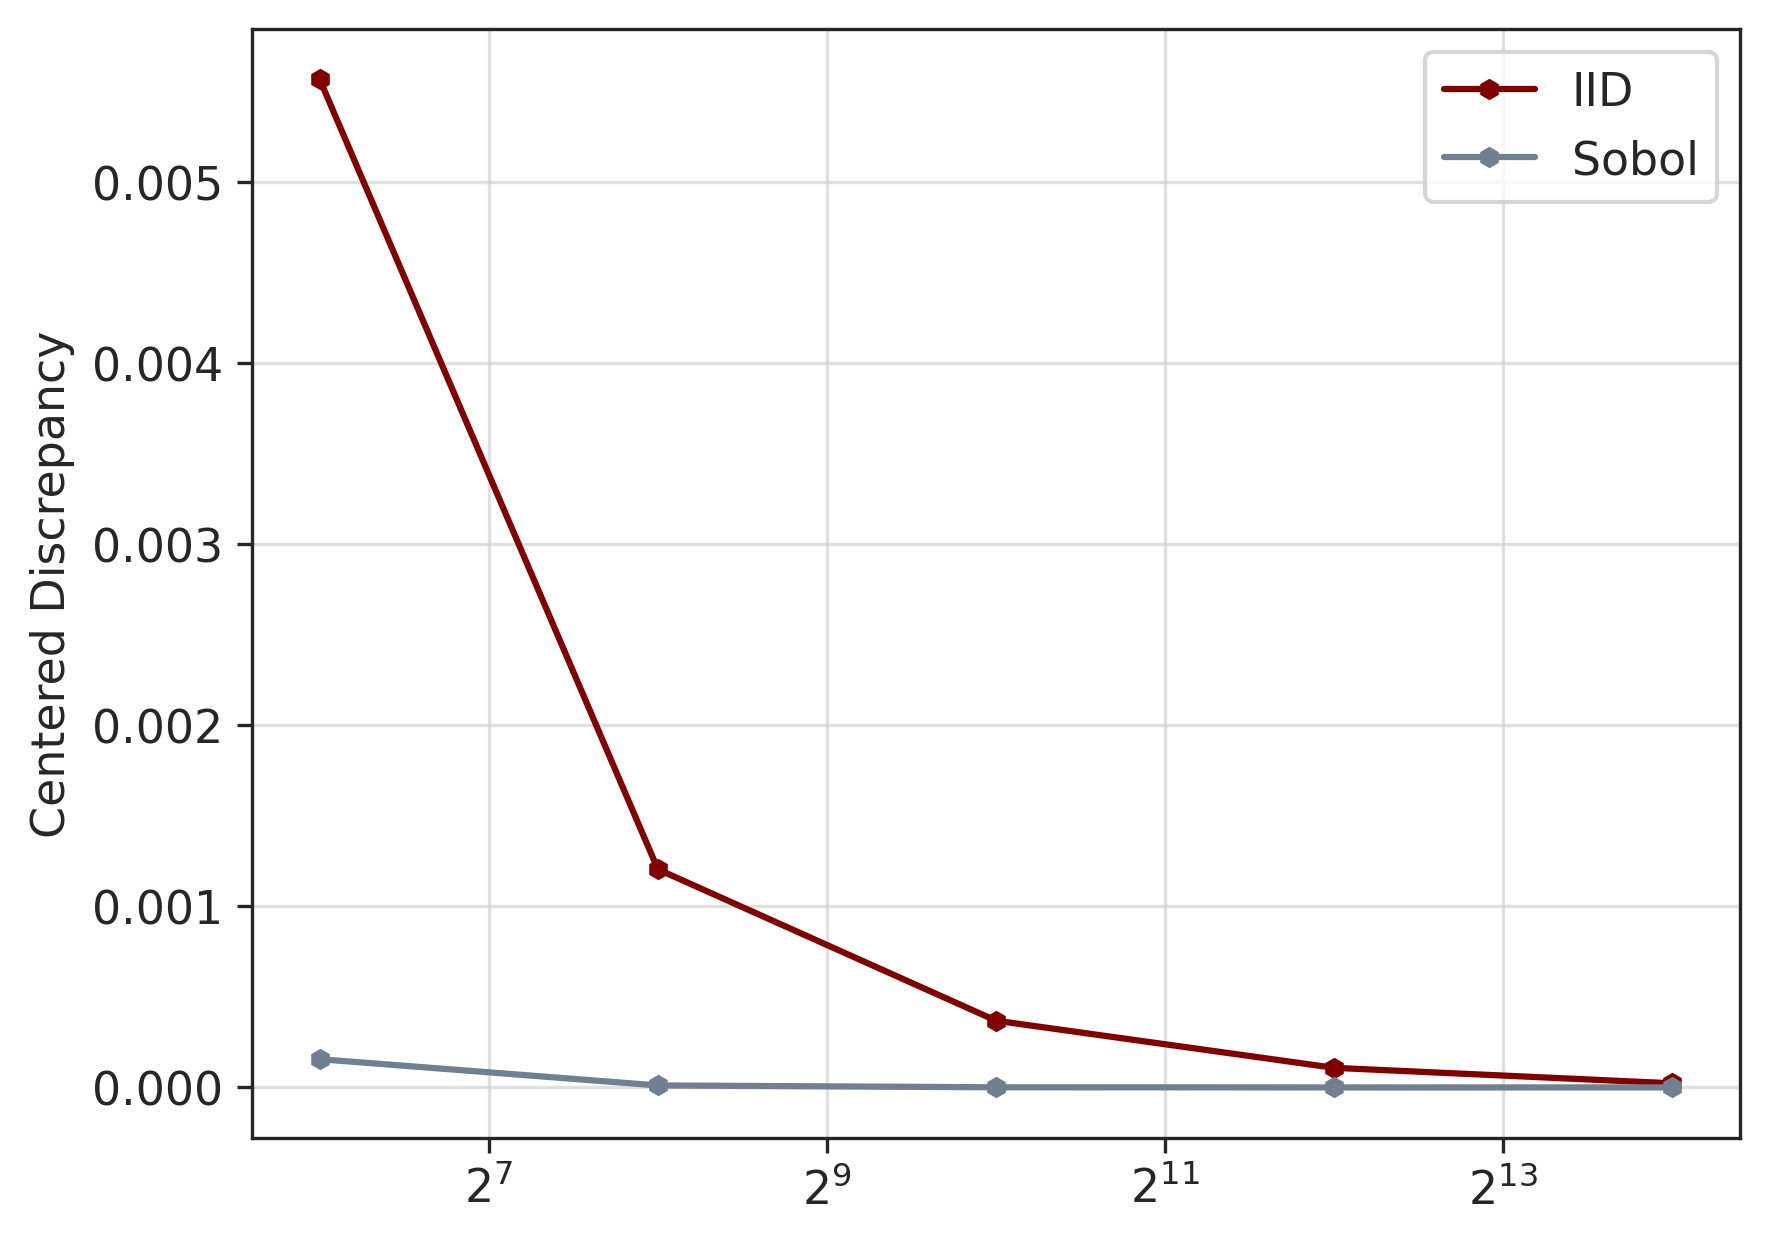

In [42]:
mean_discrepancies_IID_sobol_plotter(simulation_data = "discrepancies_unifo_ortho_sobol.npz", title = "Mean_discrepancies_IDD_OS.png")

## Sobol vs Orthogonal in Monte Carlo

In [43]:
np.random.seed(133524)
s_values = np.array([np.power(2, i) for i in range(6,19,2)])
i = 1000
re_low, re_high = -2, 1
im_low, im_high = 0, 1.5
number_of_batches = 200
mean_areas = np.empty((2, len(s_values)))
sample_variances = np.empty((2, len(s_values)))
npz_filename = "ortho_sobol_mc_both_optimal.npz"
if not exists(npz_filename):
    for k,s in enumerate(s_values):
        areas_batch = np.empty((2,number_of_batches))
        for l in range(number_of_batches):
            samples_ortho = create_batch_orthogonal(s, re_low, re_high, im_low, im_high, np.random.randint(2**31))
            samples_sobol = create_batch_sobol(s, re_low, re_high, im_low, im_high, np.random.randint(2**31))
            iter_counts_ortho = mandelbrot_mc_default(i, samples_ortho)
            iter_counts_sobol = mandelbrot_mc_default(i, samples_sobol)
            area_ortho = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts_ortho, i)
            area_sobol = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts_sobol, i)
            areas_batch[0][l] = area_ortho
            areas_batch[1][l] = area_sobol
        μo, σsqo = sample_mean_variance(areas_batch[0])
        μs, σsqs = sample_mean_variance(areas_batch[1])
        mean_areas[0][k] = μo
        sample_variances[0][k] = σsqo
        mean_areas[1][k] = μs
        sample_variances[1][k] = σsqs
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']

In [44]:
def mc_both_OS_Sobol_optimal_plotter(simulation_data, title):
    
    s_values = np.array([np.power(2, i) for i in range(6,19,2)])
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    sample_variances = data['arr_1']*2
    
    plt.plot(s_values, sample_variances[0], label = "OS", color = "chocolate", marker = "h", markersize = 4)
    plt.plot(s_values, sample_variances[1], label = "Sobol", color = "slategray", marker = "h", markersize = 4)
    plt.ylabel("Sample variance ($N = 200$)")
    plt.xlabel("Sample size ($s$)")
    plt.grid(alpha = 0.6)
    plt.xscale('log', basex=2)
    plt.yscale("log")
    plt.legend()
    plt.savefig(title)
    plt.show()

<ipython-input-44-384176417fd8>:15: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=2)


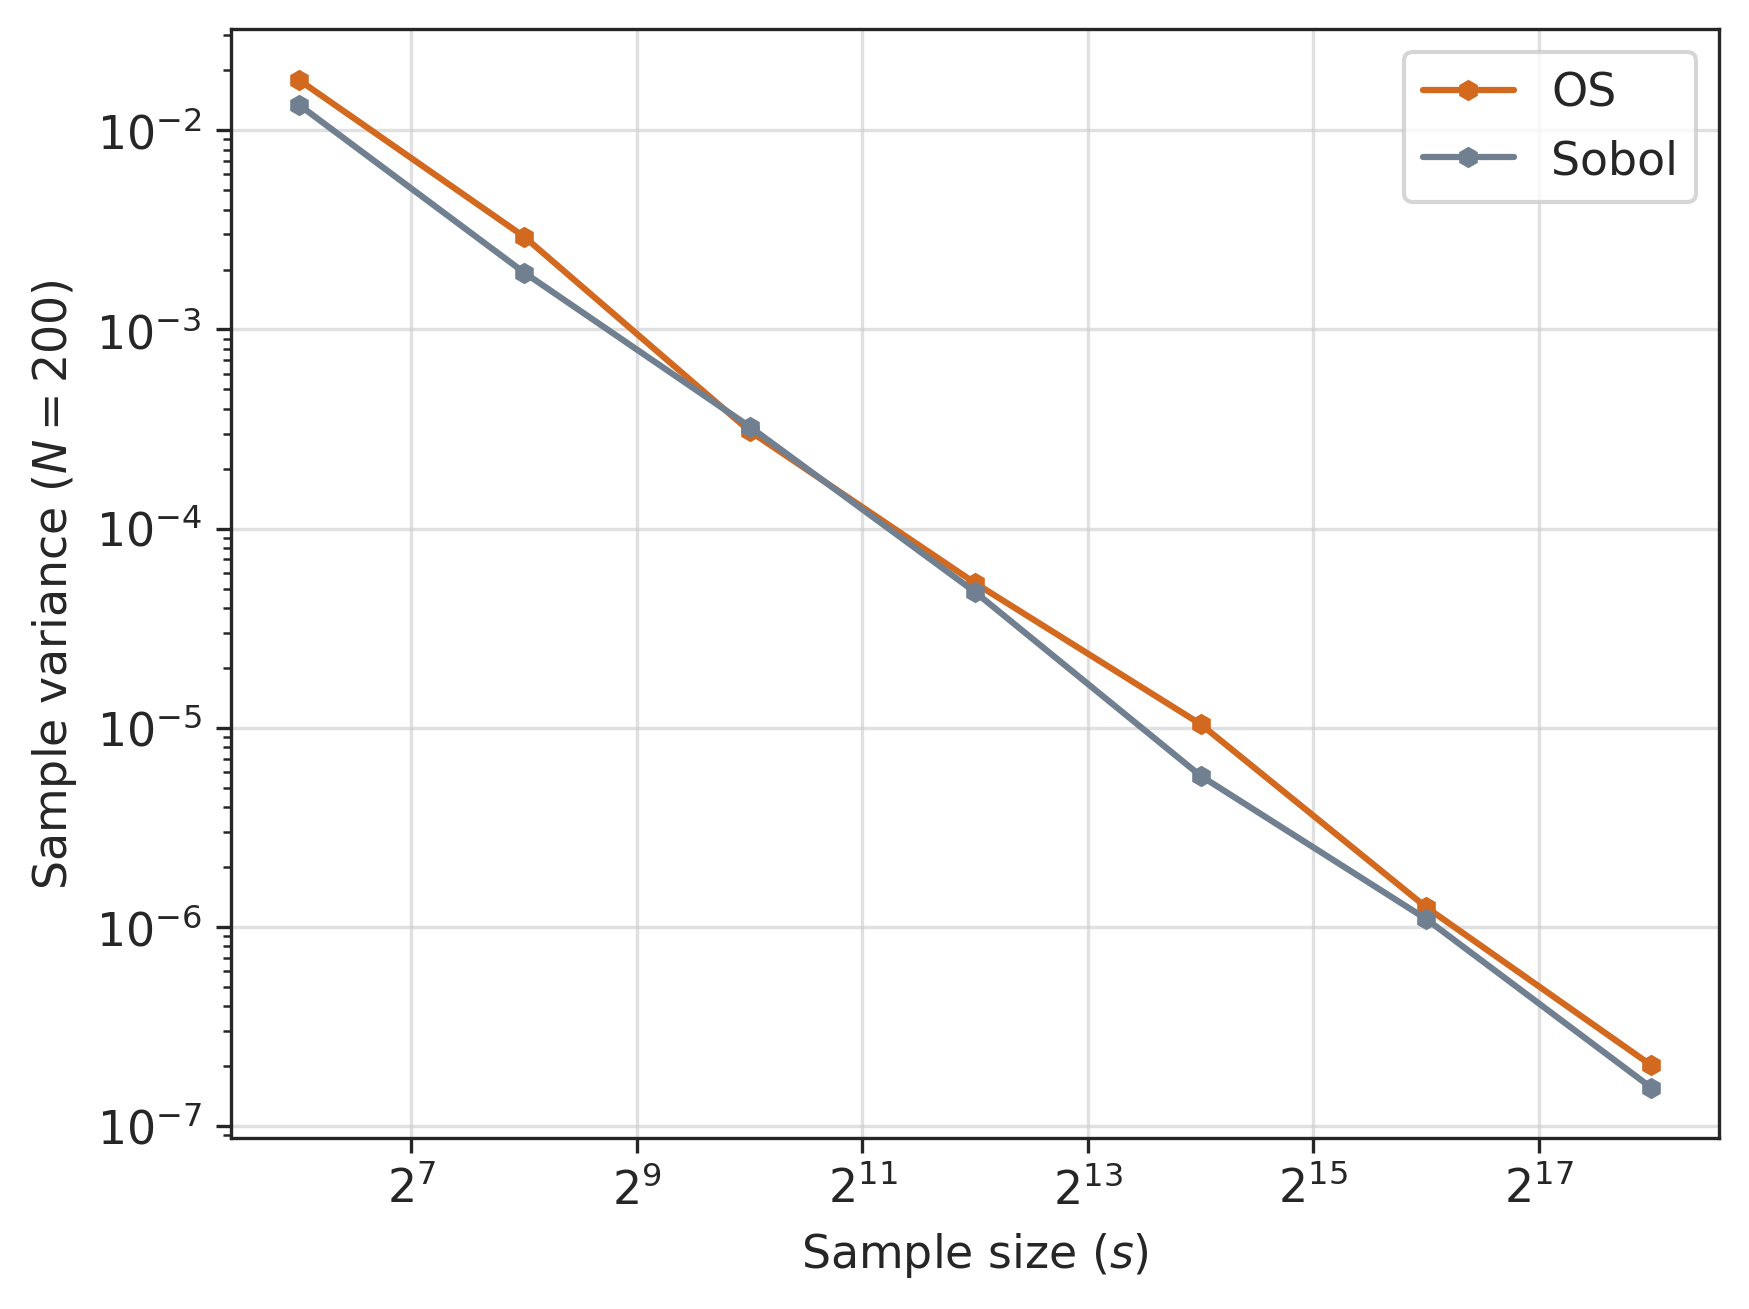

In [45]:
mc_both_OS_Sobol_optimal_plotter(simulation_data = "ortho_sobol_mc_both_optimal.npz", title = "Both_Ortho_Sobol_Optimal.png")

In [46]:
# TODO write if not exist

np.random.seed(133524)
s_values = np.array([np.power(2, i) for i in range(6,19)])  # includes non-squares
i = 1000
re_low, re_high = -2, 1
im_low, im_high = 0, 1.5
number_of_batches = 200
mean_areas = np.empty((2, len(s_values)))
sample_variances = np.empty((2, len(s_values)))
npz_filename = "ortho_sobol_mc_sobol_optimum.npz"
if not exists(npz_filename):
    for k,s in enumerate(s_values):
        areas_batch = np.empty((2,number_of_batches))
        for l in range(number_of_batches):
            samples_ortho = create_batch_orthogonal(s, re_low, re_high, im_low, im_high, np.random.randint(2**31))
            samples_sobol = create_batch_sobol(s, re_low, re_high, im_low, im_high, np.random.randint(2**31))
            iter_counts_ortho = mandelbrot_mc_default(i, samples_ortho)
            iter_counts_sobol = mandelbrot_mc_default(i, samples_sobol)
            area_ortho = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts_ortho, i)
            area_sobol = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts_sobol, i)
            areas_batch[0][l] = area_ortho
            areas_batch[1][l] = area_sobol
        μo, σsqo = sample_mean_variance(areas_batch[0])
        μs, σsqs = sample_mean_variance(areas_batch[1])
        mean_areas[0][k] = μo
        sample_variances[0][k] = σsqo
        mean_areas[1][k] = μs
        sample_variances[1][k] = σsqs
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']

In [47]:
def mc_Sobol_optimum_plotter(simulation_data, title):
    
    s_values = np.array([np.power(2, i) for i in range(6,19)]) 
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    sample_variances = data['arr_1']*2 #multiply by 2
    
    plt.plot(s_values, sample_variances[0], label = "OS", color = "chocolate", marker = "h", markersize = 4)
    plt.plot(s_values, sample_variances[1], label = "Sobol", color = "slategray", marker = "h", markersize = 4)
    plt.ylabel("Sample variance ($N = 200$)")
    plt.xlabel("Sample size ($s$)")
    plt.grid(alpha = 0.6)
    plt.xscale('log', basex=2)
    plt.yscale("log")
    plt.legend()
    plt.savefig(title)
    plt.show()


<ipython-input-47-5dd68294139d>:15: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=2)


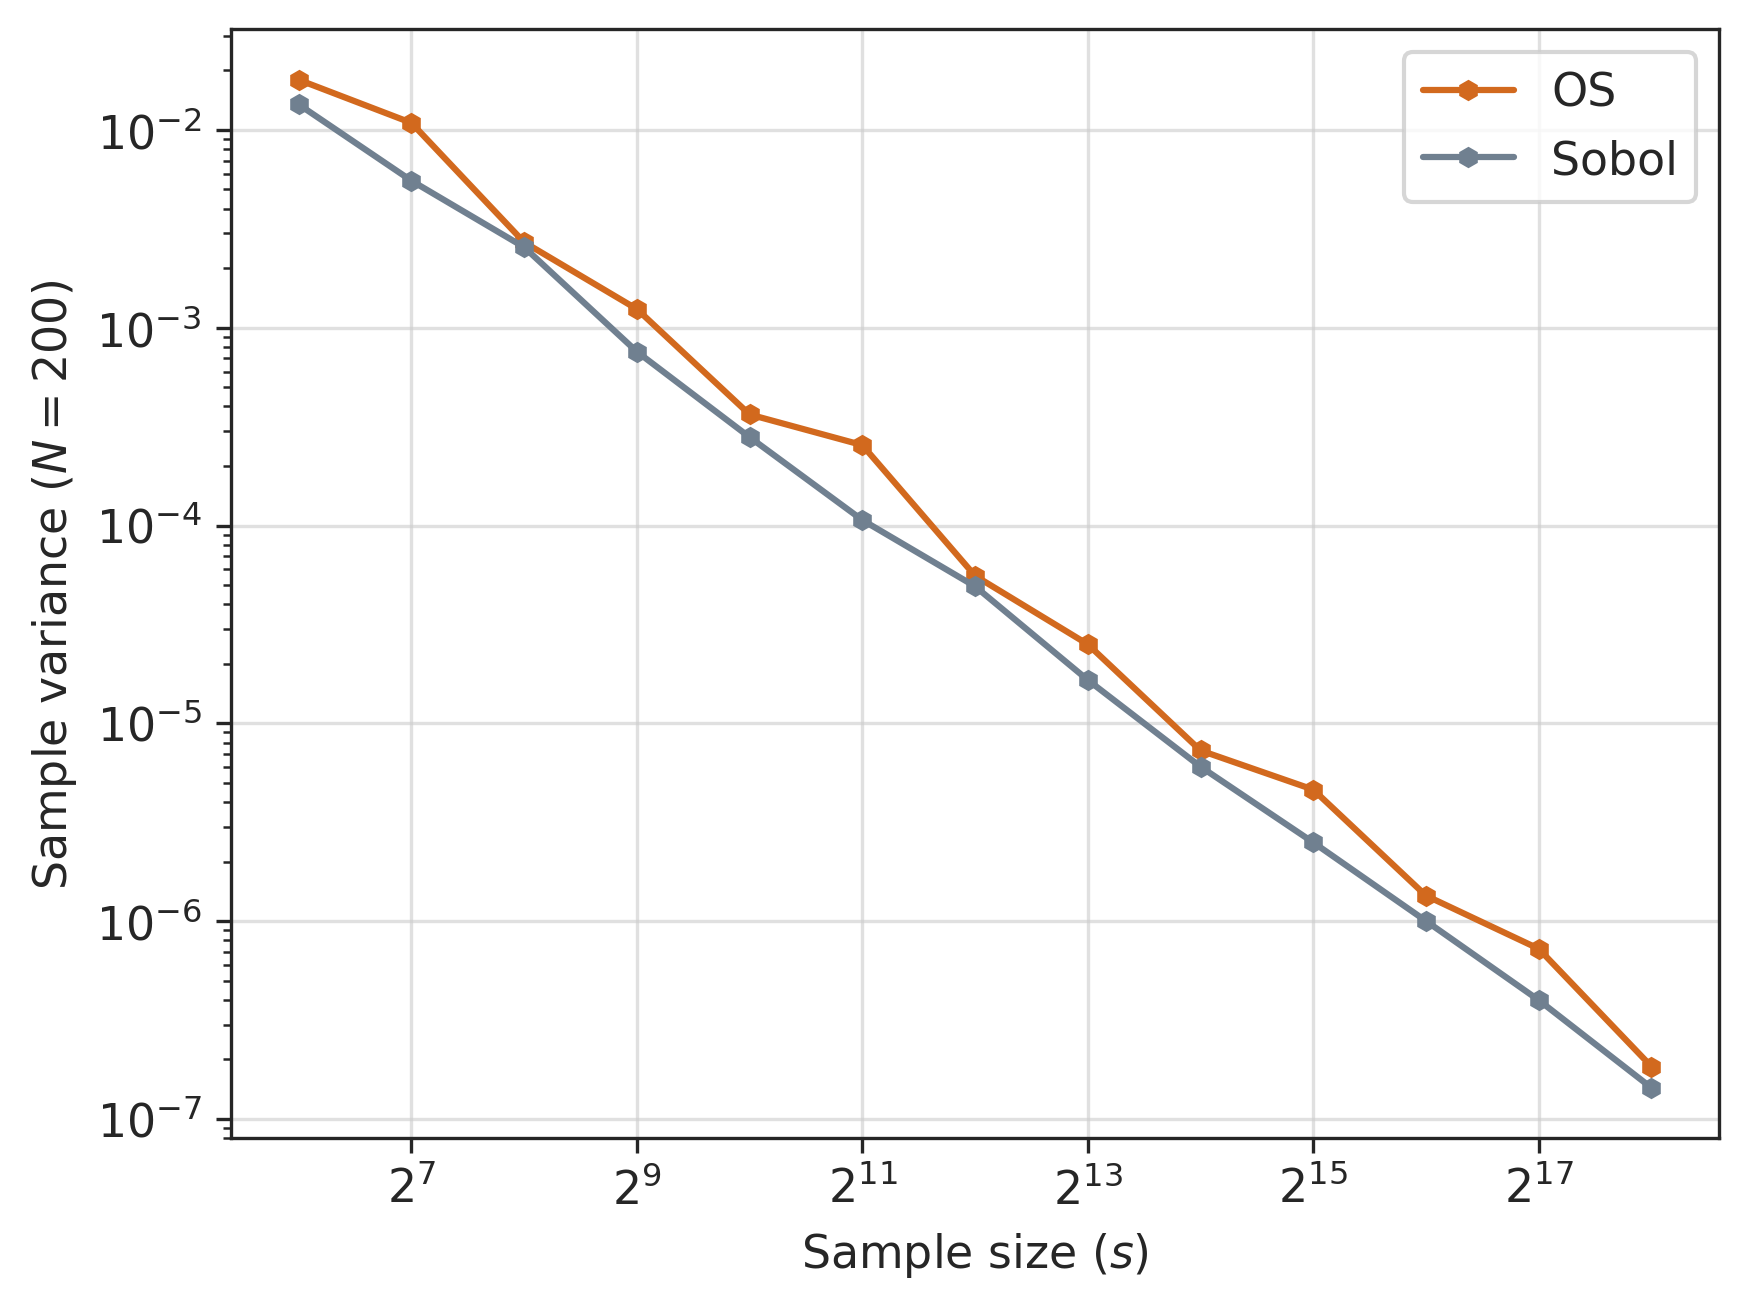

In [48]:
mc_Sobol_optimum_plotter(simulation_data = "ortho_sobol_mc_sobol_optimum.npz", title = "Sobol_optimum.png")

In [49]:
np.random.seed(133524)
s_values = np.array([np.power(i,2) for i in range(10,71,5)])

i = 1000
re_low, re_high = -2, 1
im_low, im_high = 0, 1.5
number_of_batches = 200
mean_areas = np.empty((2, len(s_values)))
sample_variances = np.empty((2, len(s_values)))
npz_filename = "ortho_sobol_mc_ortho_optimized.npz"
if not exists(npz_filename):
    for k,s in enumerate(s_values):
        areas_batch = np.empty((2,number_of_batches))
        for l in range(number_of_batches):
            samples_ortho = create_batch_orthogonal(s, re_low, re_high, im_low, im_high, np.random.randint(2**31))
            samples_sobol = create_batch_sobol(s, re_low, re_high, im_low, im_high, np.random.randint(2**31))
            iter_counts_ortho = mandelbrot_mc_default(i, samples_ortho)
            iter_counts_sobol = mandelbrot_mc_default(i, samples_sobol)
            area_ortho = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts_ortho, i)
            area_sobol = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts_sobol, i)
            areas_batch[0][l] = area_ortho
            areas_batch[1][l] = area_sobol
        μo, σsqo = sample_mean_variance(areas_batch[0])
        μs, σsqs = sample_mean_variance(areas_batch[1])
        mean_areas[0][k] = μo
        sample_variances[0][k] = σsqo
        mean_areas[1][k] = μs
        sample_variances[1][k] = σsqs
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']

In [50]:
def mc_ortho_optimized_plotter(simulation_data, title):
    
    s_values = np.array([np.power(i,2) for i in range(10,71,5)])
    
    data = np.load(simulation_data)

    mean_areas = data['arr_0']*2
    sample_variances = data['arr_1']*2
    
    plt.plot(s_values, sample_variances[0], label = "OS", color = "chocolate", marker = "h", markersize = 4)
    plt.plot(s_values, sample_variances[1], label = "Sobol", color = "slategray", marker = "h", markersize = 4)
    plt.ylabel("Sample variance ($N = 200$)")
    plt.xlabel("Sample size ($s$)")
    plt.grid(alpha = 0.6)
    plt.xscale('log', basex=2)
    plt.yscale("log")
    plt.legend()
    plt.savefig(title)
    plt.show()

<ipython-input-50-e7bf5c785421>:15: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=2)


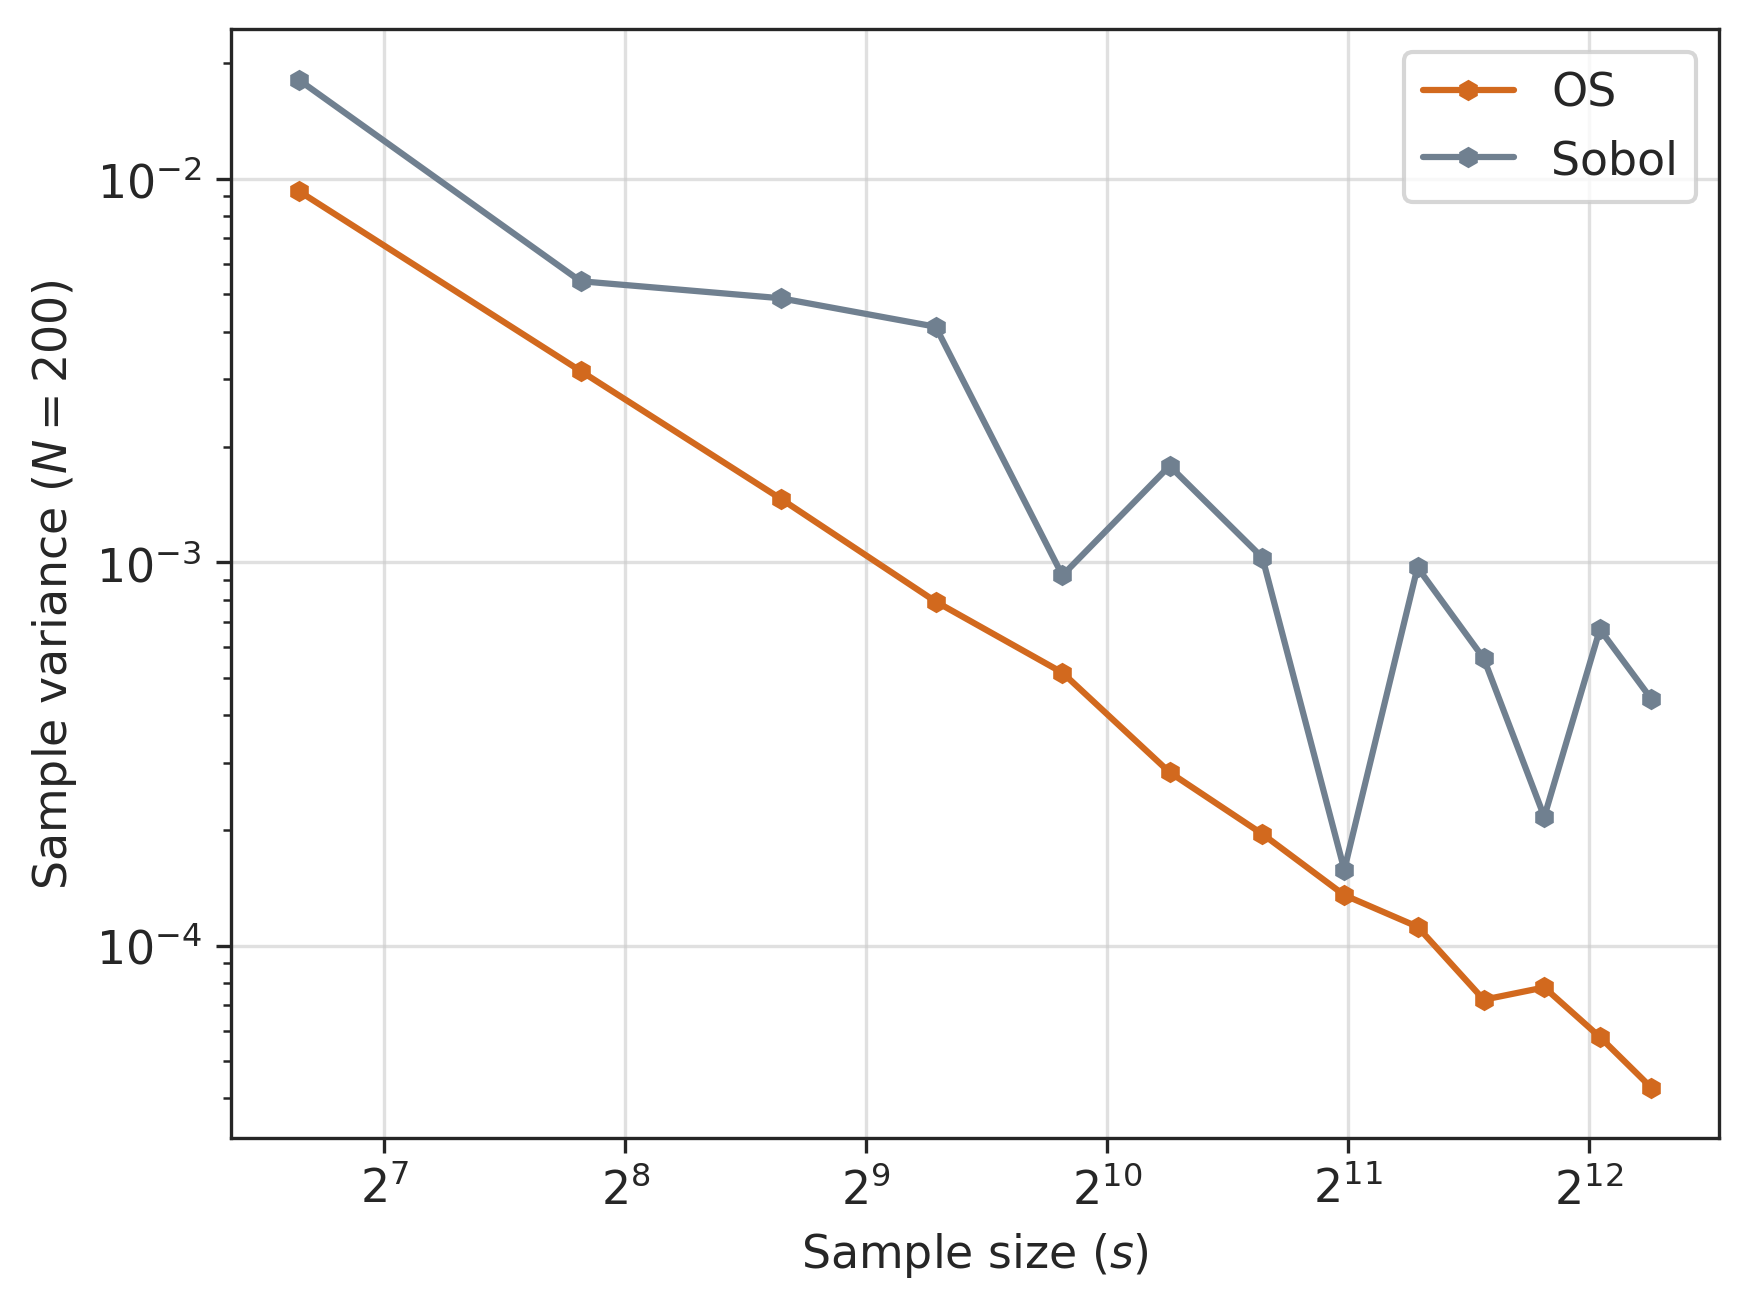

In [51]:
mc_ortho_optimized_plotter(simulation_data = "ortho_sobol_mc_ortho_optimized.npz", title = "Optimited_OS.png")

In [52]:
np.random.seed(133524)

s = np.power(2, 20)
i = 1000

re_low, re_high = -2, 1
im_low, im_high = 0, 1.5

number_of_batches = 200
areas = np.empty((2, number_of_batches))

npz_filename = "ortho_sobol_vplot_data.npz"
if not exists(npz_filename):
    for l in range(number_of_batches):
        samples_ortho = create_batch_orthogonal(s, re_low, re_high, im_low, im_high, np.random.randint(2**31))
        samples_sobol = create_batch_sobol(s, re_low, re_high, im_low, im_high, np.random.randint(2**31))
        iter_counts_ortho = mandelbrot_mc_default(i, samples_ortho)
        iter_counts_sobol = mandelbrot_mc_default(i, samples_sobol)
        area_ortho = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts_ortho, i)
        area_sobol = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts_sobol, i)
        areas[0][l] = area_ortho
        areas[1][l] = area_sobol
    np.savez(npz_filename, areas)
else:
    save_data = np.load(npz_filename)
    areas = save_data['arr_0']

In [55]:
def OS_Sobol_ttest_violinplot(simulation_data, title):
    
    """"
    Plots boxplot from simualation data 
    using seaborn's `violinplot`
    
    """
    
    data = np.load(simulation_data)
    
    areas = data['arr_0']*2
    
    f, p = f_test(areas[0], areas[1])
    
    heading_length = 80
    
    def _heading(text):
        return dashed_heading(text, heading_length)
        
    
    if p < 0.5:
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of OS equals to variance of Sobol")
        print("F-test statistic is:", f, " and  p-value is:", p)
        conclusion = "Null Hypothesis is rejected."
        
    else:
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of OS equals to variance of Sobol")
        print("F-test statistic is:", f, " and  p-value is:", p)
        conclusion = "Failed to reject the null hypothesis."
        
    print(conclusion)

    
    palette = sns.xkcd_palette(['pumpkin', 'greyish blue'])
  
    df = pd.DataFrame(np.transpose(areas), columns = ["OS", "Sobol"])
    
    fig = sns.violinplot(data=df, palette=palette)
    
    plt.xlabel("Sampling Methods")
    plt.ylabel("Mean approximated area $A_{i,s}$")
    plt.savefig(title, bbox_inches = 'tight')

In [56]:
OS_Sobol_ttest_violinplot(simulation_data = "ortho_sobol_vplot_data.npz", title = "Violinplot.png")

--------------------------------TEST STATISTICS---------------------------------
H0: Variance of OS equals to variance of Sobol
F-test statistic is: 1.4792521122740432  and  p-value is: 0.0029846604086284367
Null Hypothesis is rejected.
